In [1]:
import sys,os,time 
import h5py

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

sys.path.append('/home/nexus-admin/NEXUS_RF/BackendTools')
import PulseFitting as pf

In [2]:
day_str    = "20230216"
V_led      = 4.0
# f_avg_name = day_str+"_avg_pulses.h5"
f_avg_name = day_str+"_avg_pulses_Vled_"+str(V_led)+".h5"
data       = pd.read_hdf(f_avg_name, key="data")

temps_mK   = np.array(data.keys()[1:]).astype(float)
print(temps_mK)

[350. 325. 300. 275. 250. 225. 200. 175. 150. 125.  75.  50.  25.]


In [3]:
t0 = 4.99
pf.set_fixed_param("t0_ms",t0)
pf.show_fixed_params()

## How much attenuation is in the lines before the chip
line_atten_dB = 56.5

"t0_ms" 4.99


350mK----------
-- Parameter guess for single exponential -- 
     Decay time constant:  0.0600000000000005 ms
     Amplitude at t=0:     1.2240294779921438e+34
325mK----------
-- Parameter guess for single exponential -- 
     Decay time constant:  0.040000000000000036 ms
     Amplitude at t=0:     3.1903108115131134e+52
300mK----------
-- Parameter guess for single exponential -- 
     Decay time constant:  0.040000000000000036 ms
     Amplitude at t=0:     6.572208519521144e+52
275mK----------
-- Parameter guess for single exponential -- 
     Decay time constant:  0.040000000000000036 ms
     Amplitude at t=0:     1.0487082344541444e+53
250mK----------
-- Parameter guess for single exponential -- 
     Decay time constant:  0.05999999999999872 ms
     Amplitude at t=0:     1.3441216833884595e+35
225mK----------
-- Parameter guess for single exponential -- 
     Decay time constant:  0.09999999999999876 ms
     Amplitude at t=0:     5.997827957926541e+20
200mK----------
-- Parameter

(4.5, 10.0)

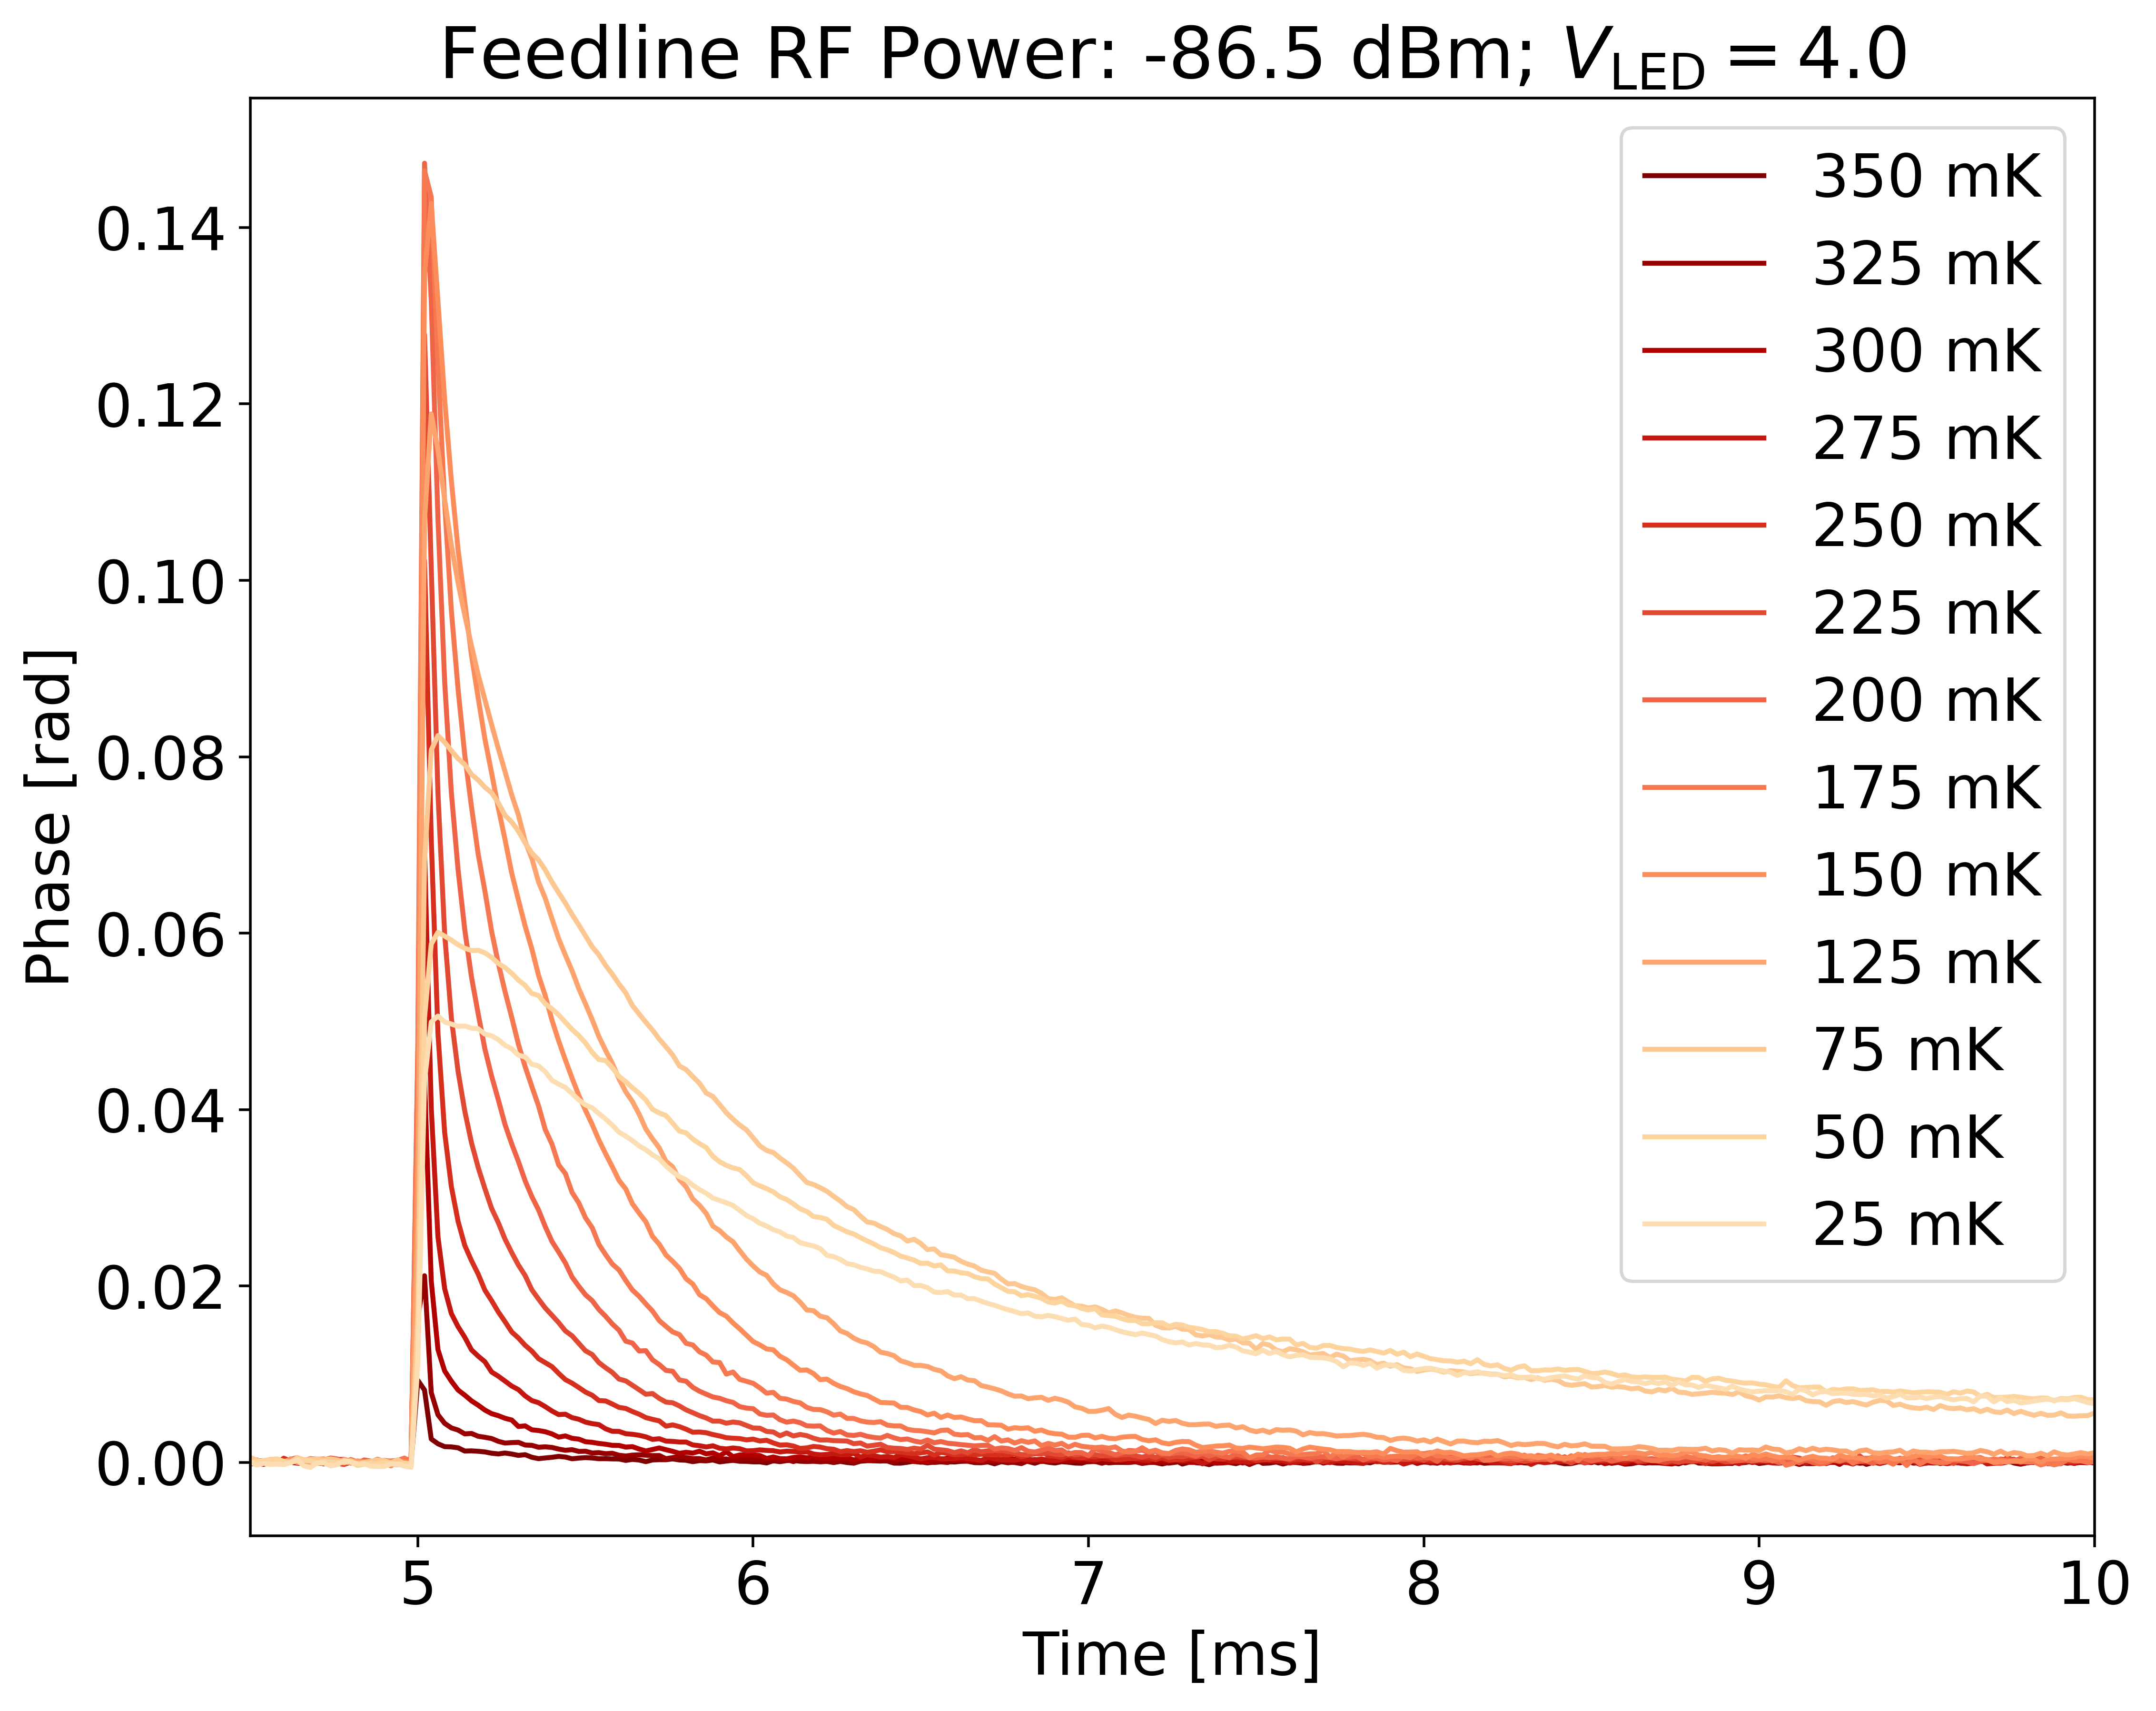

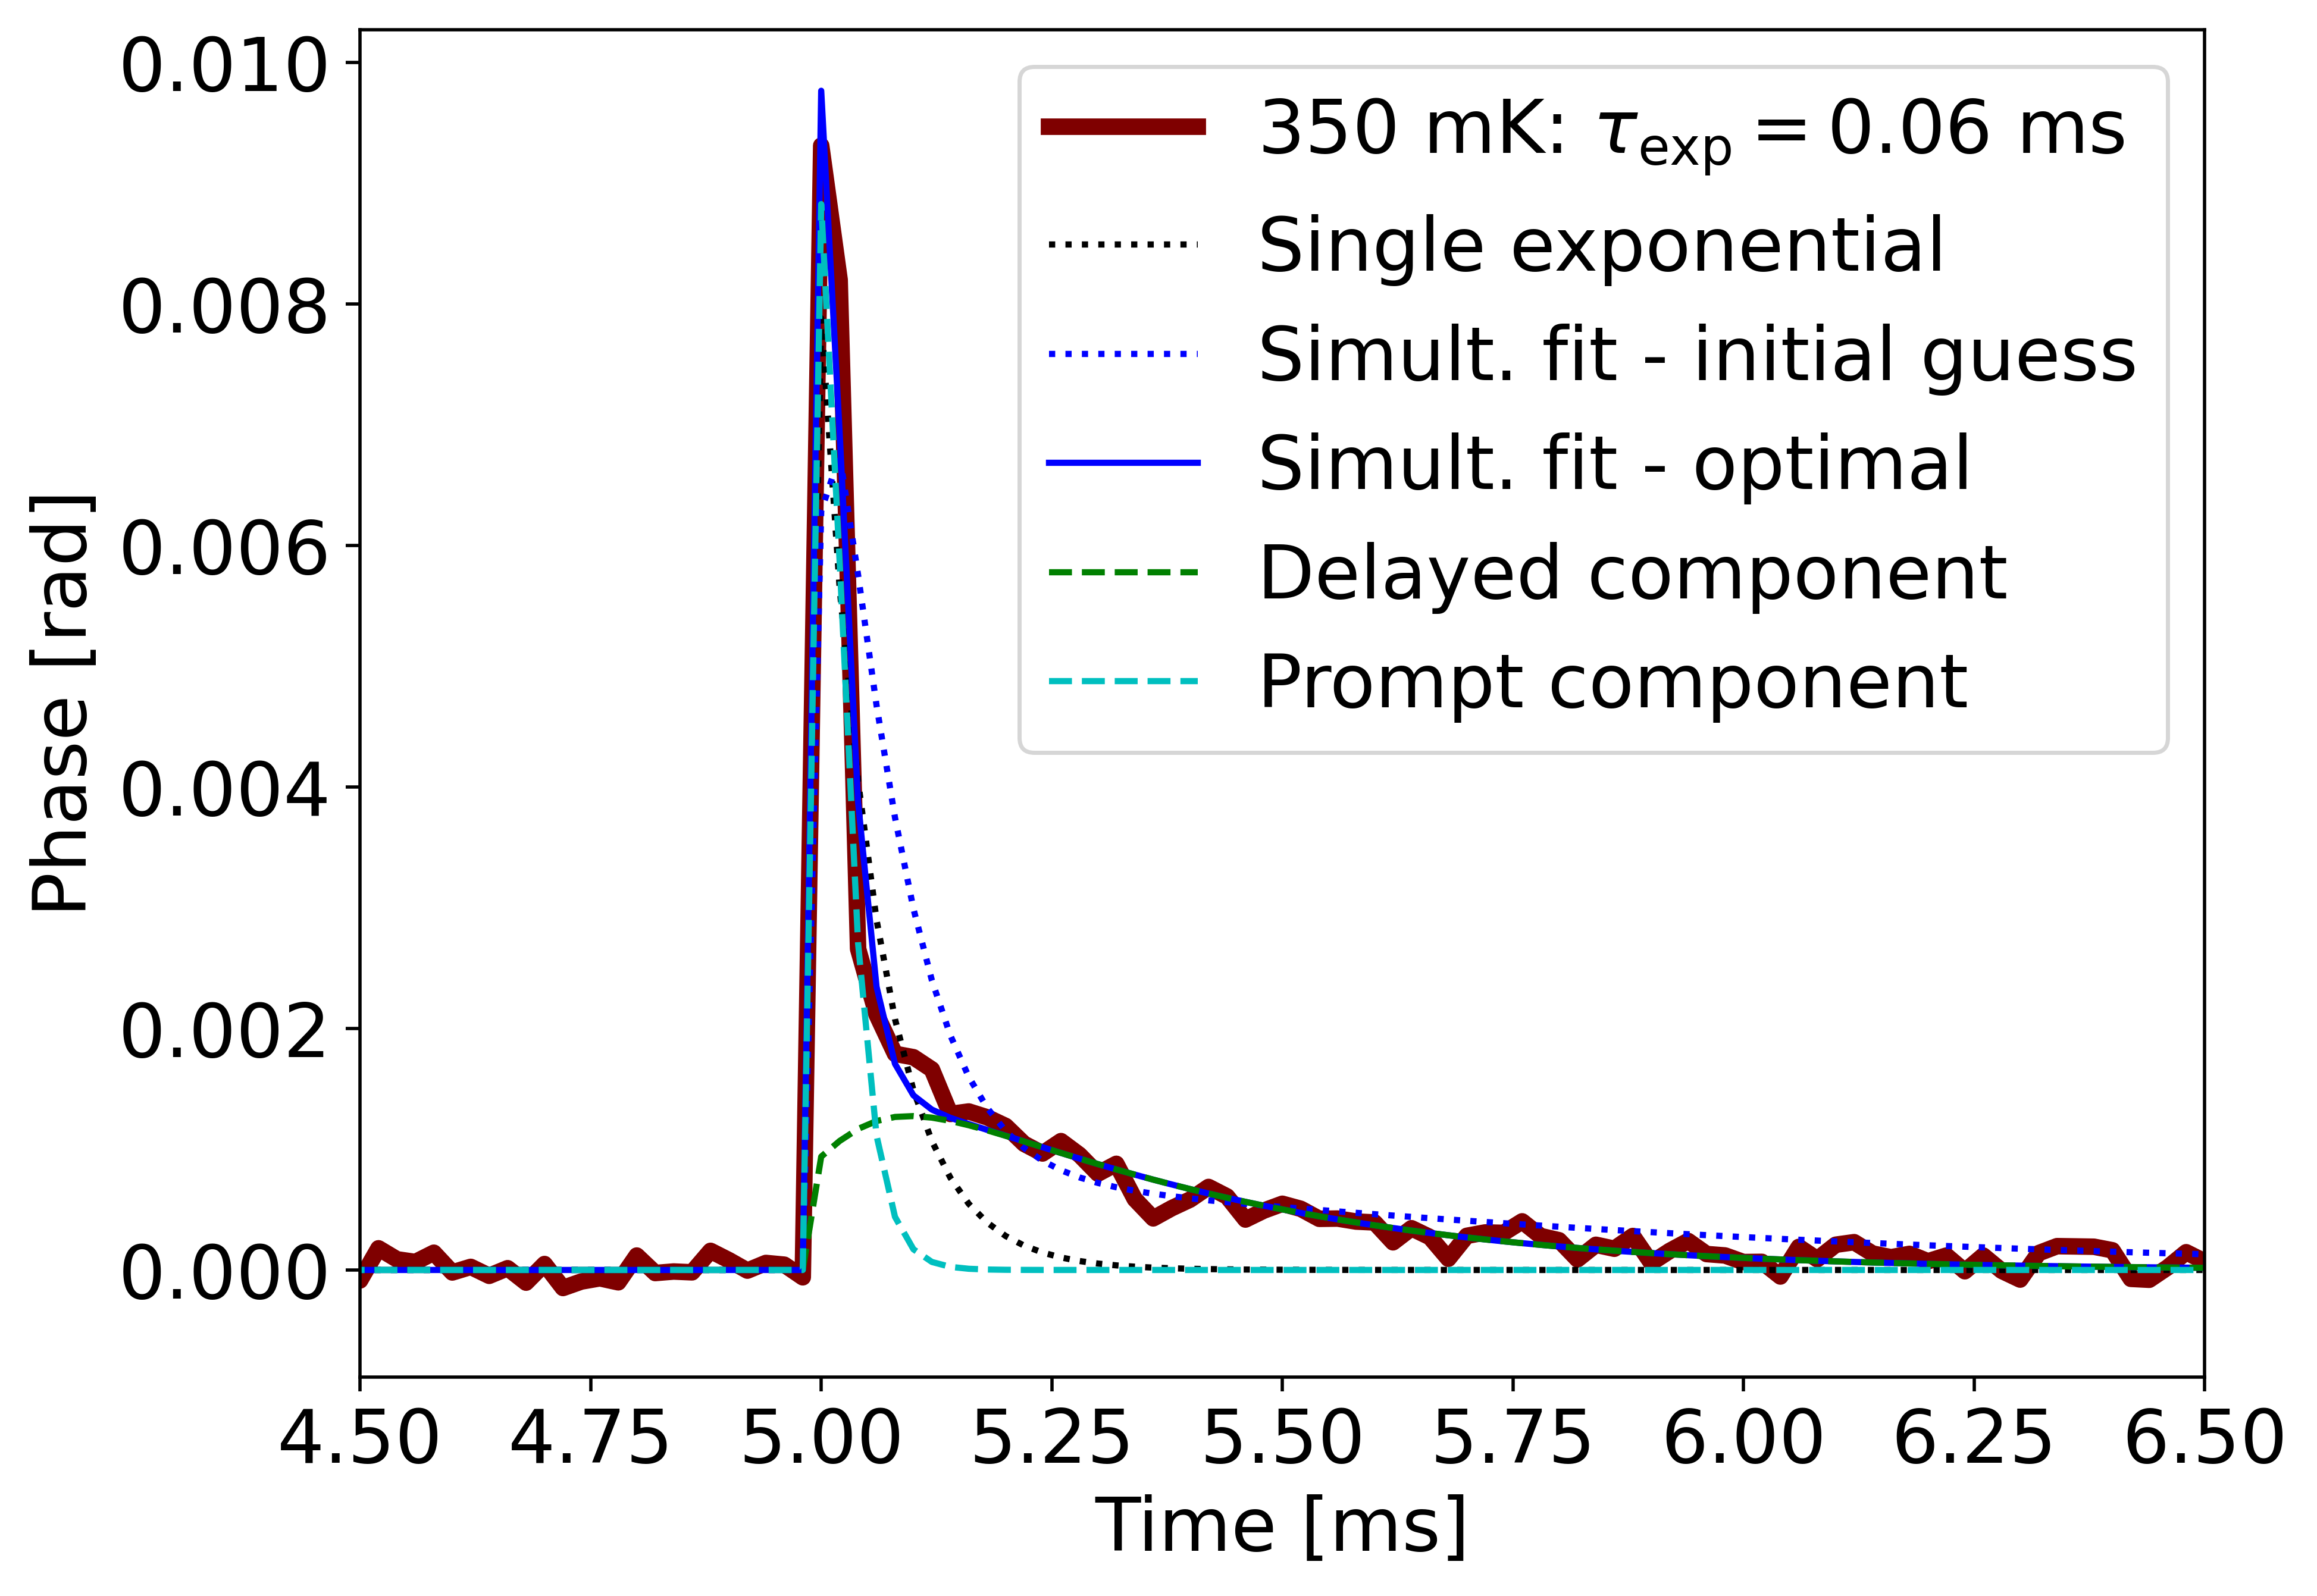

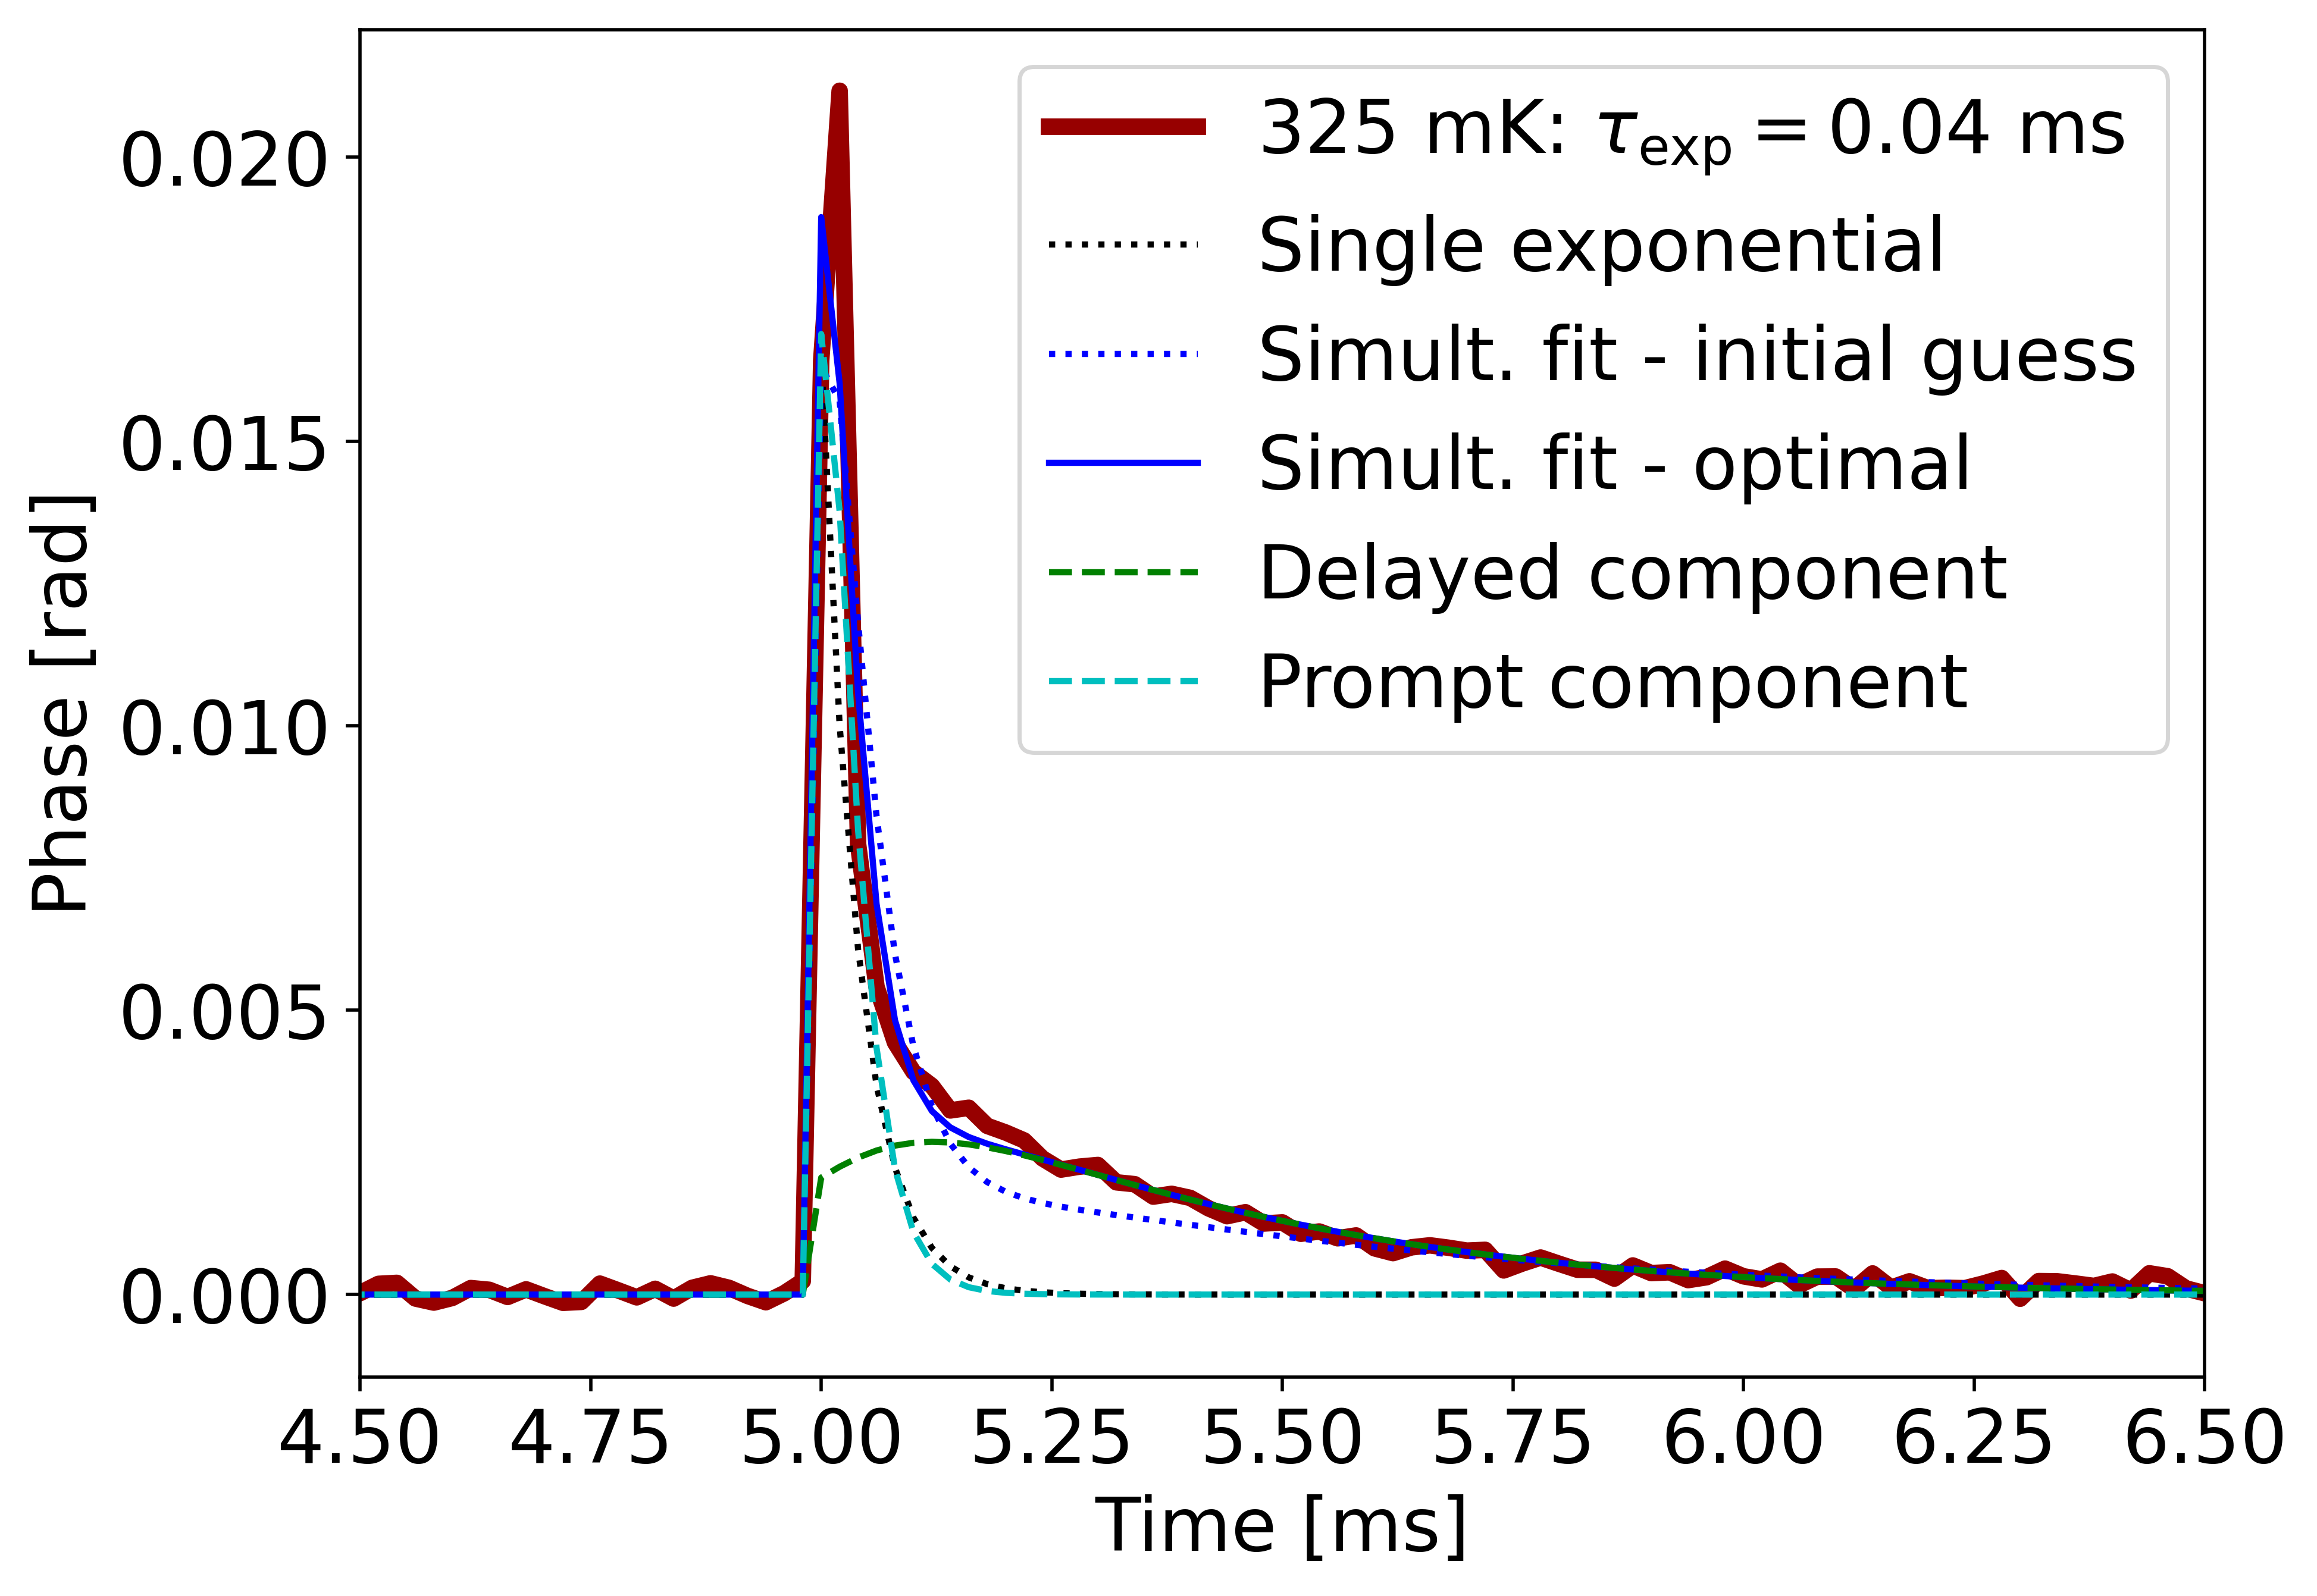

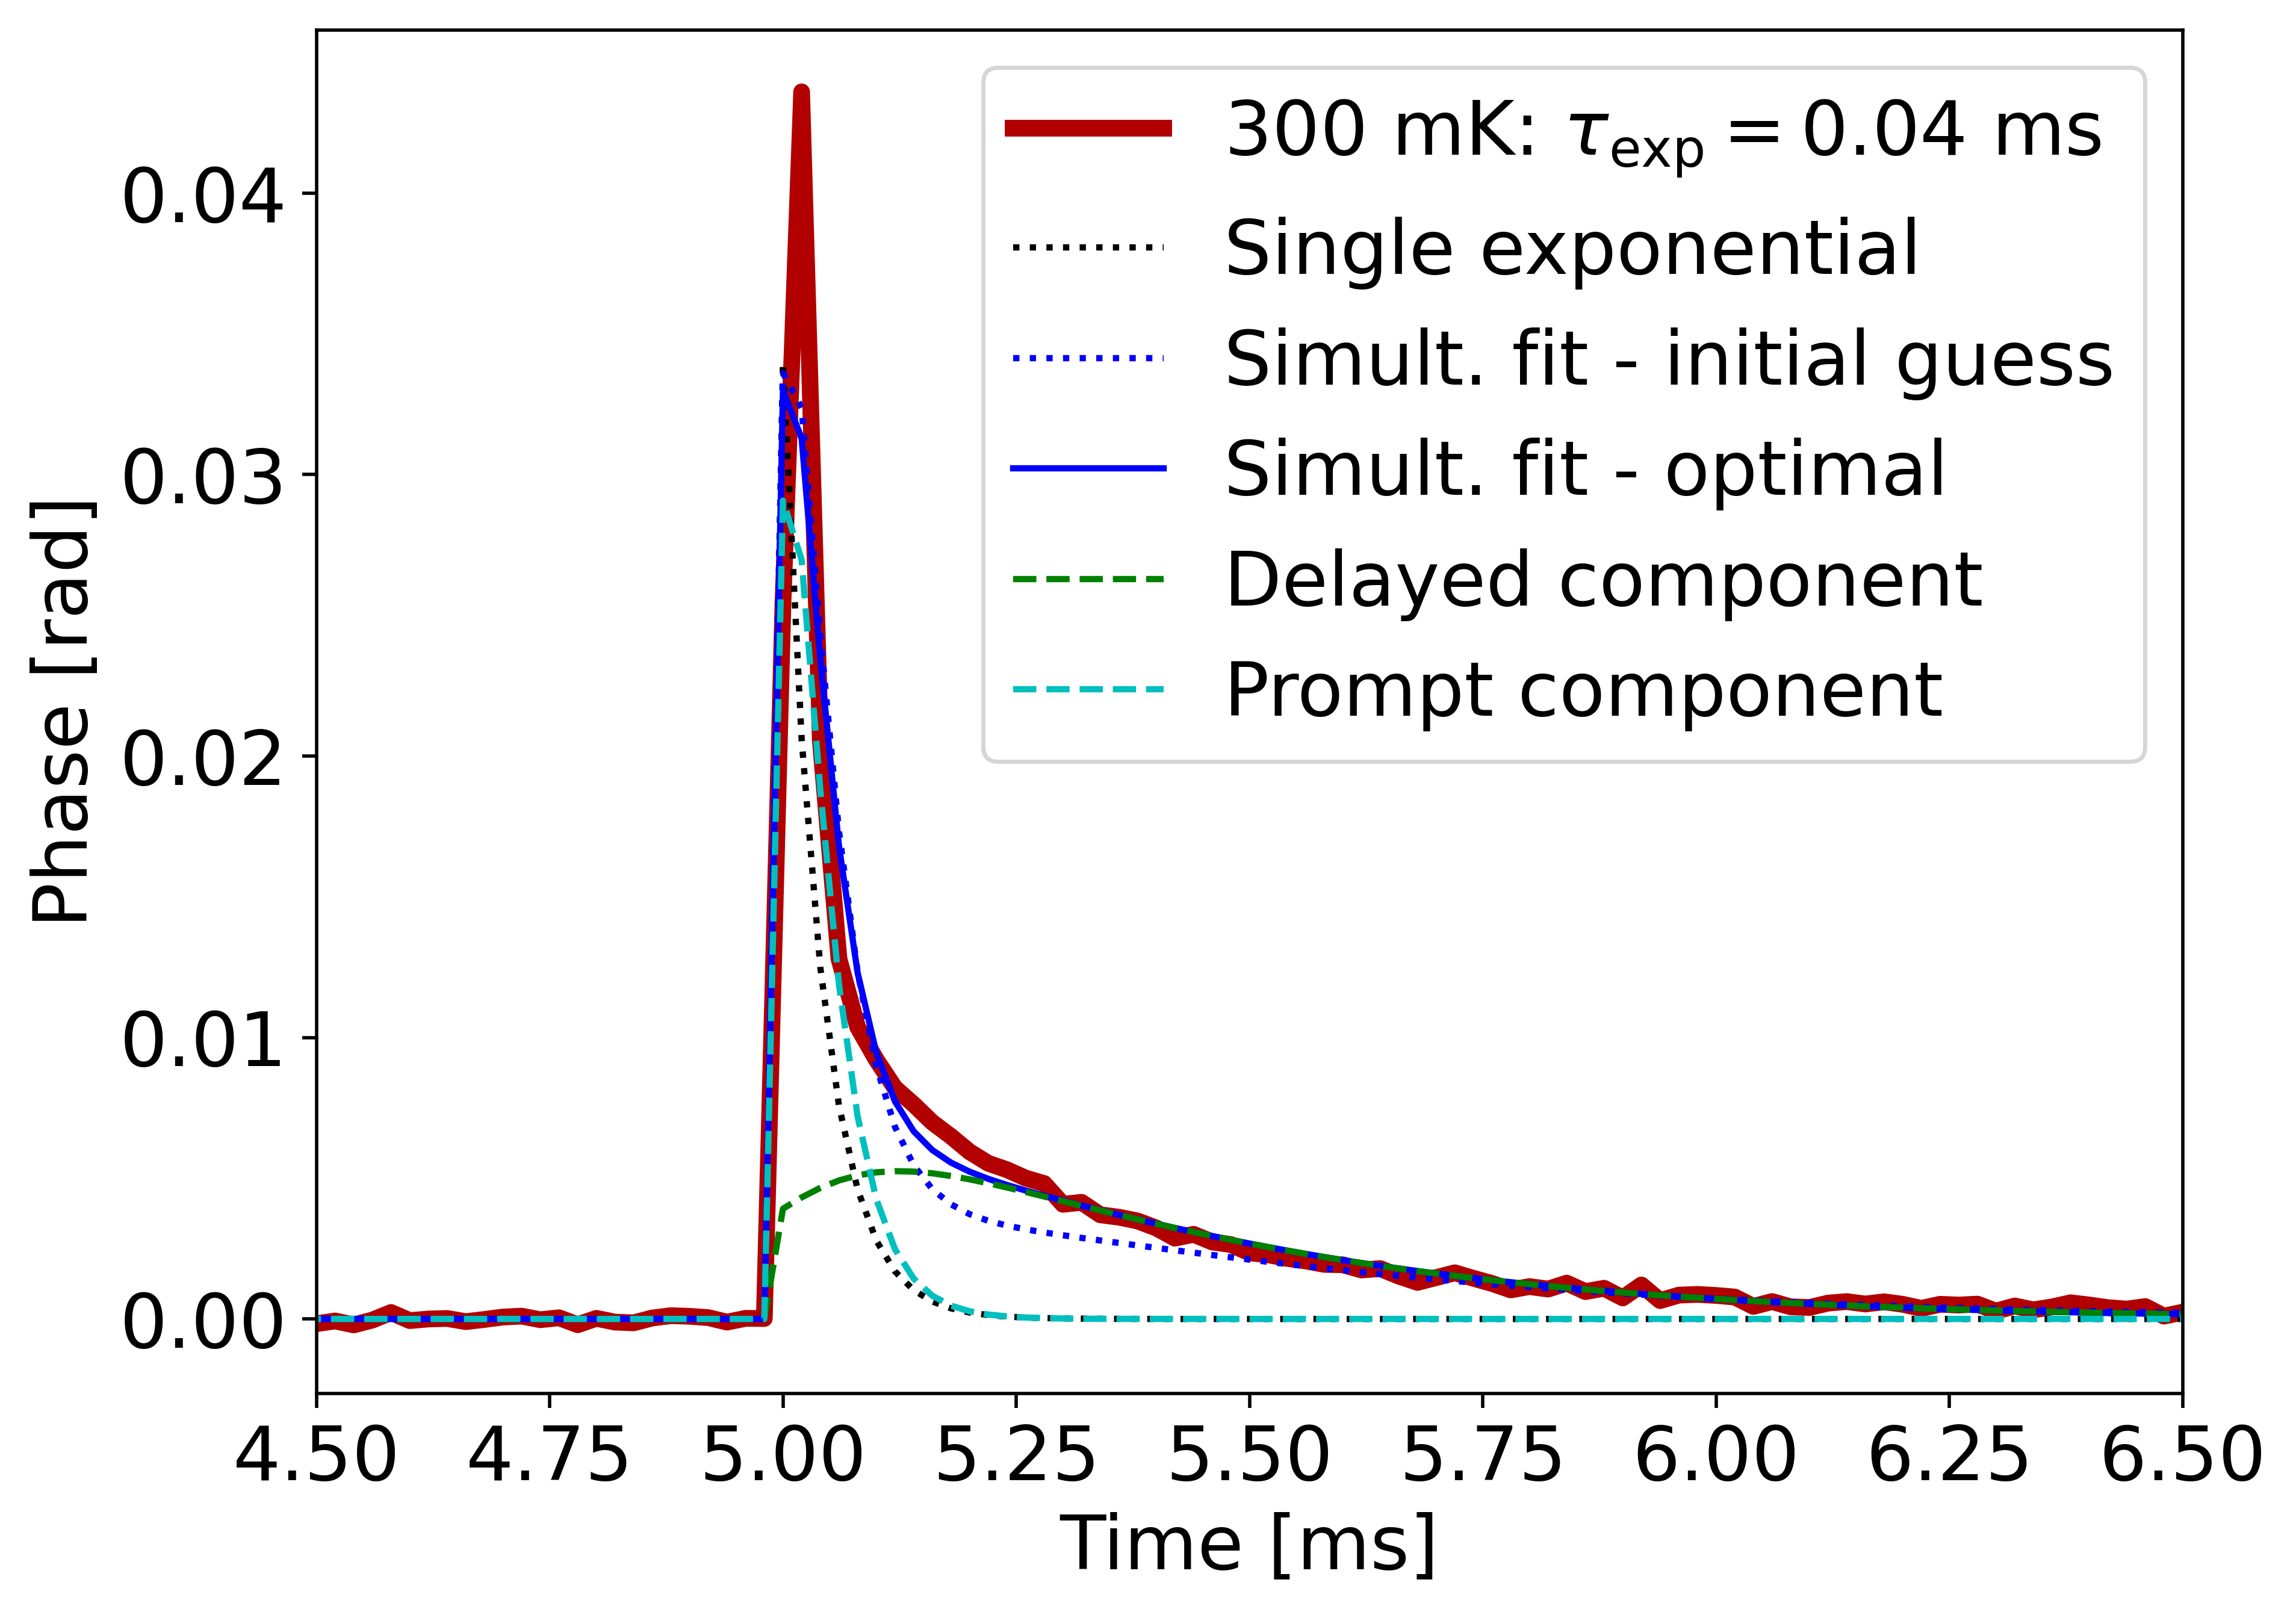

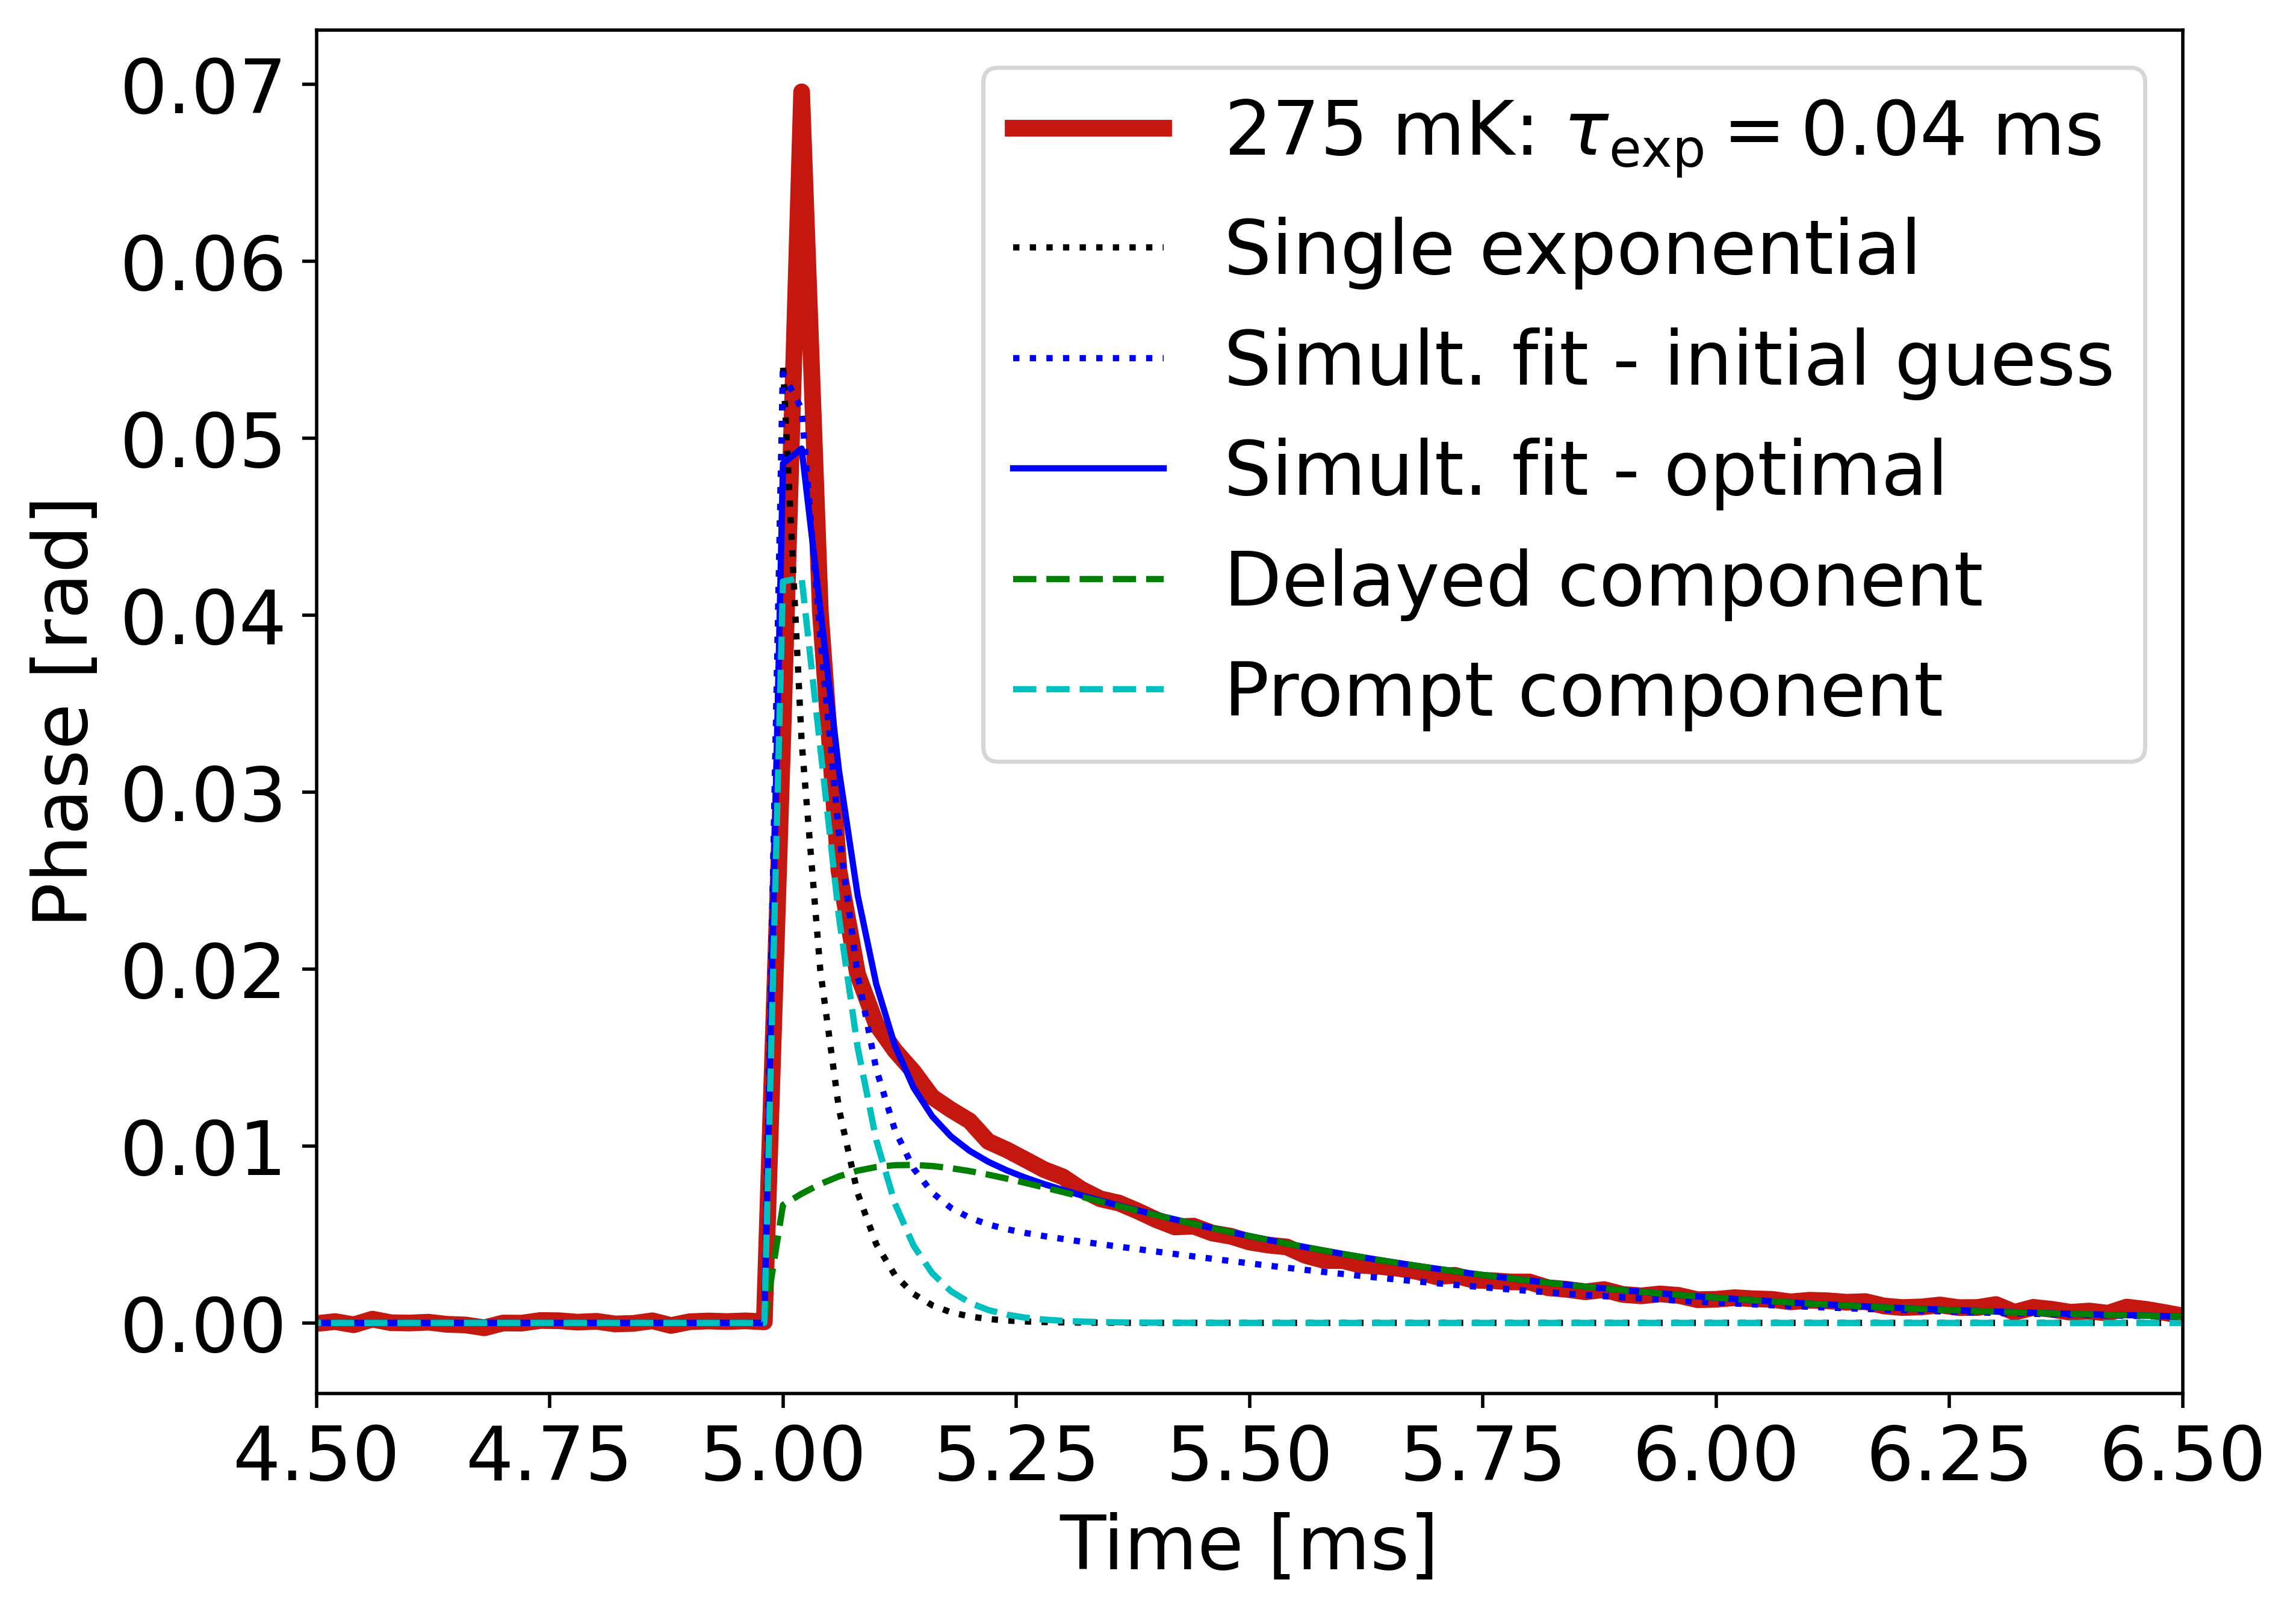

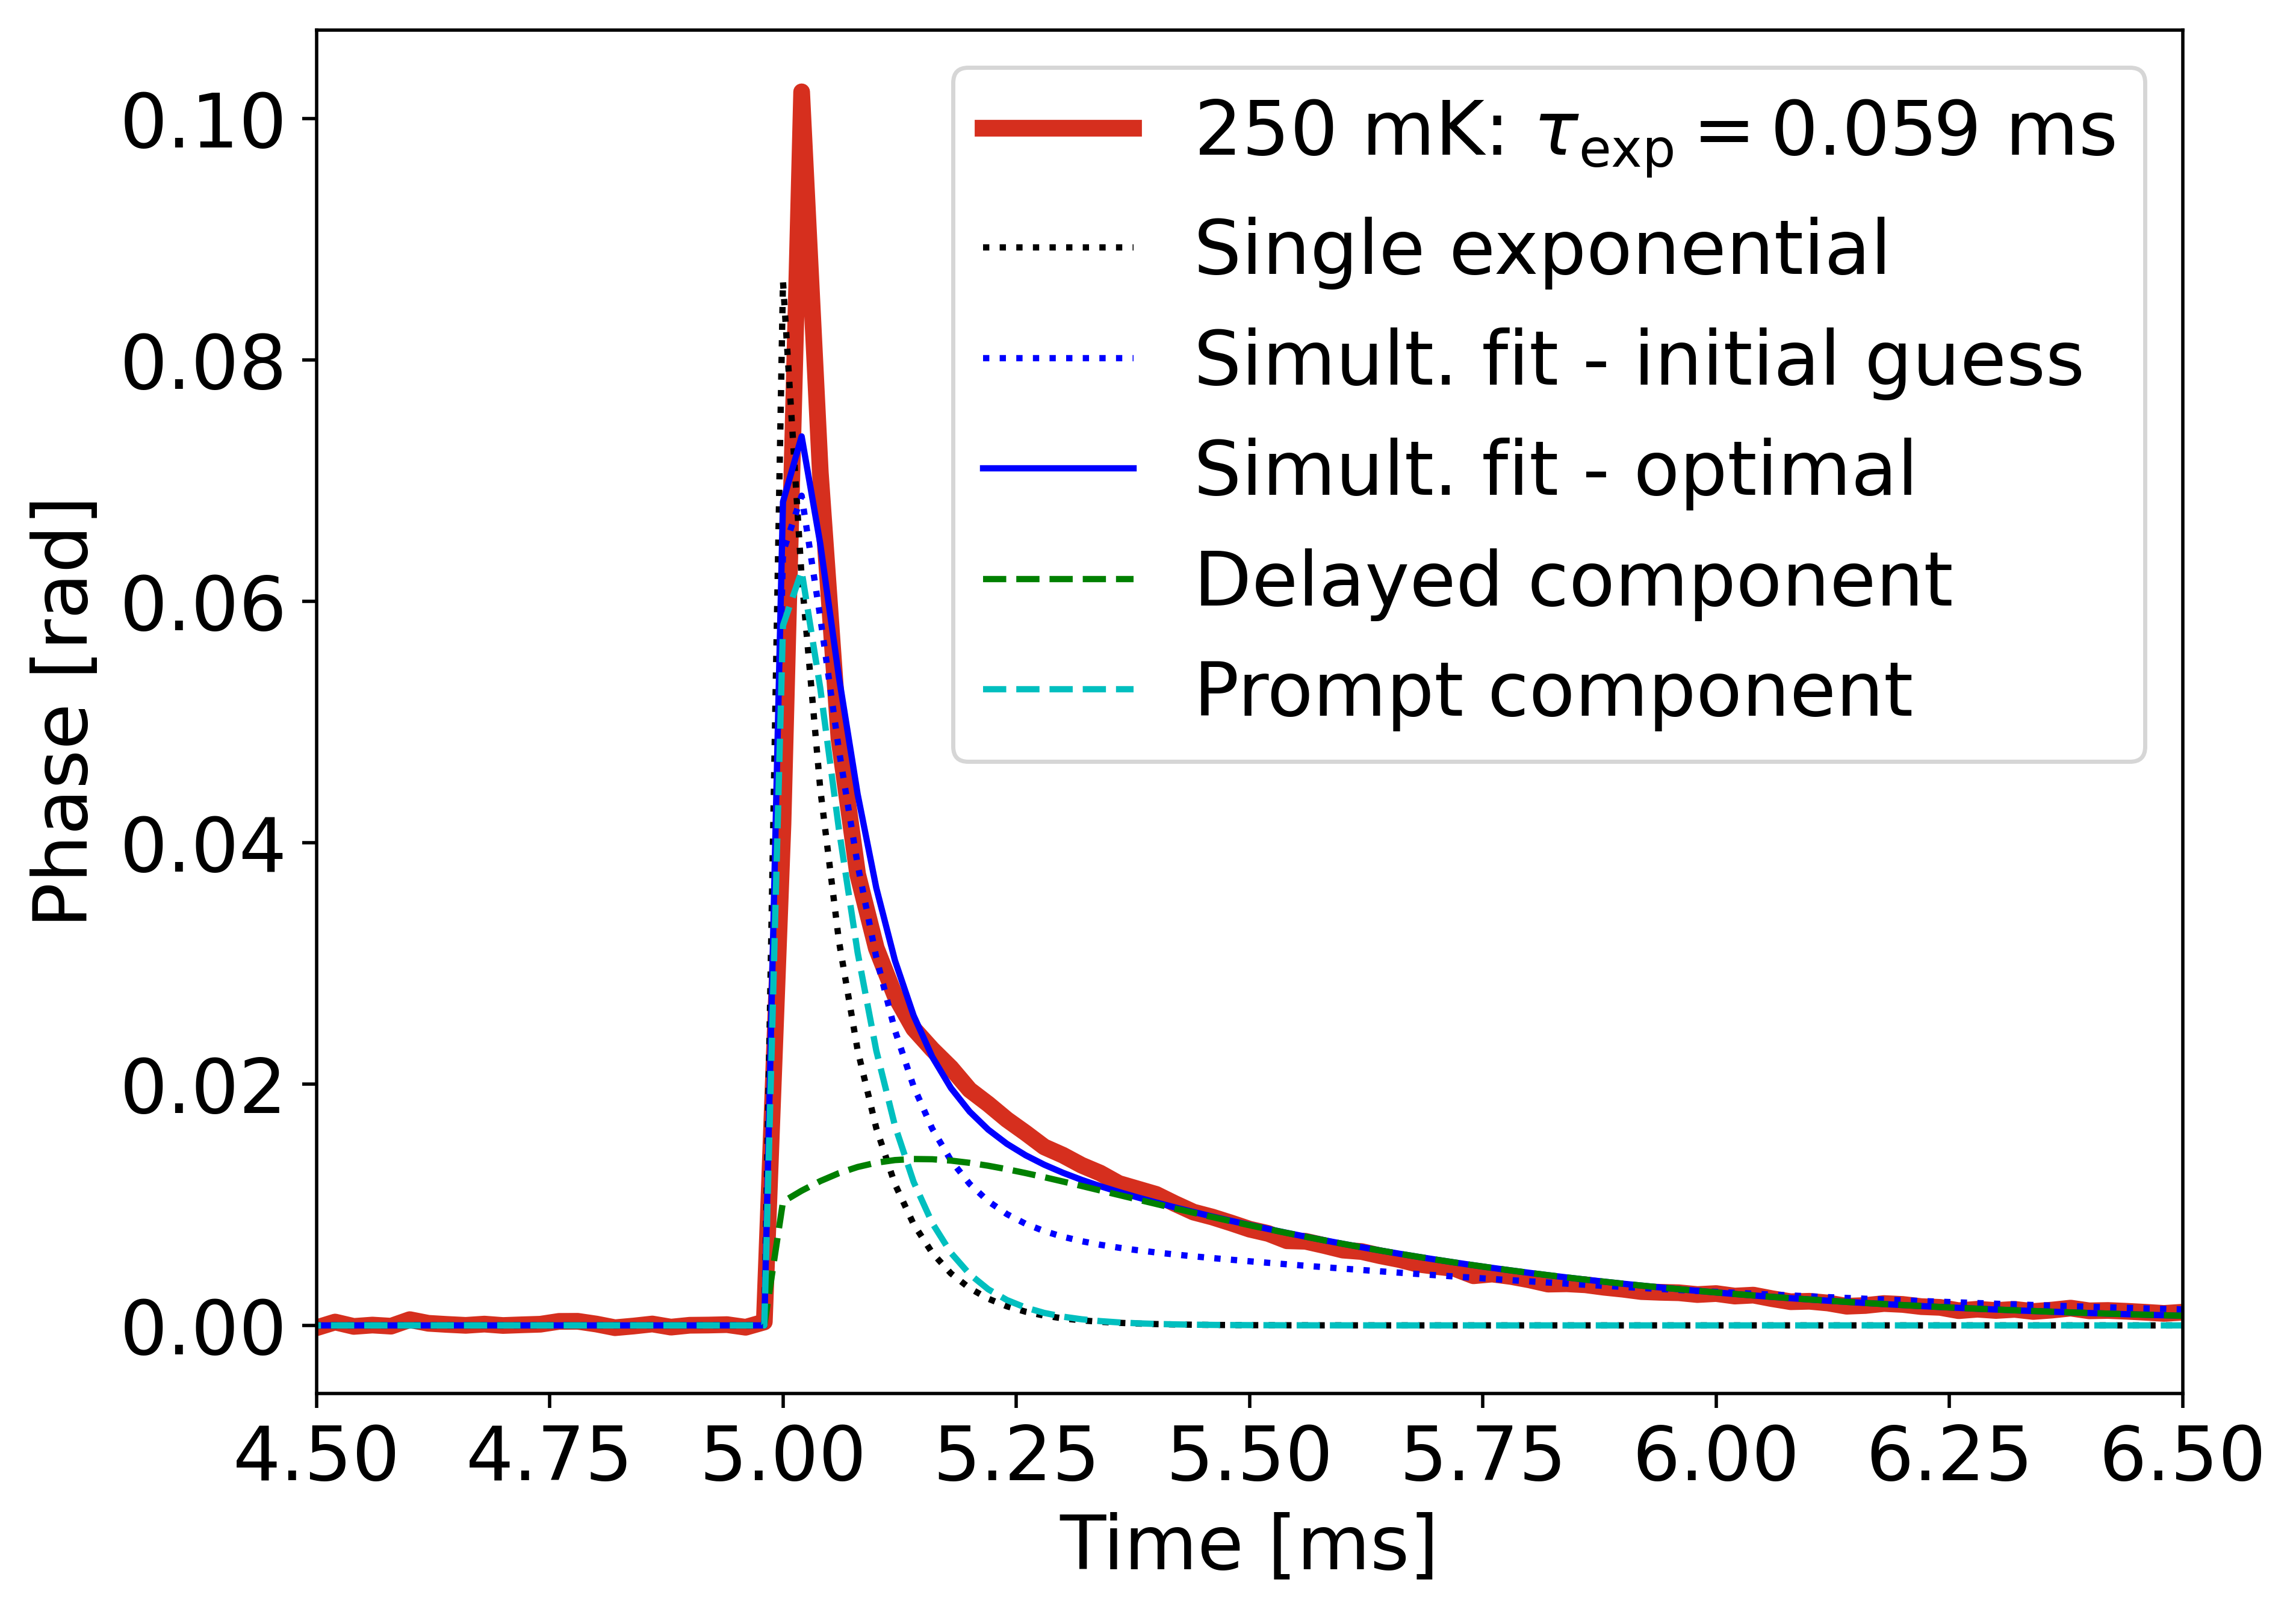

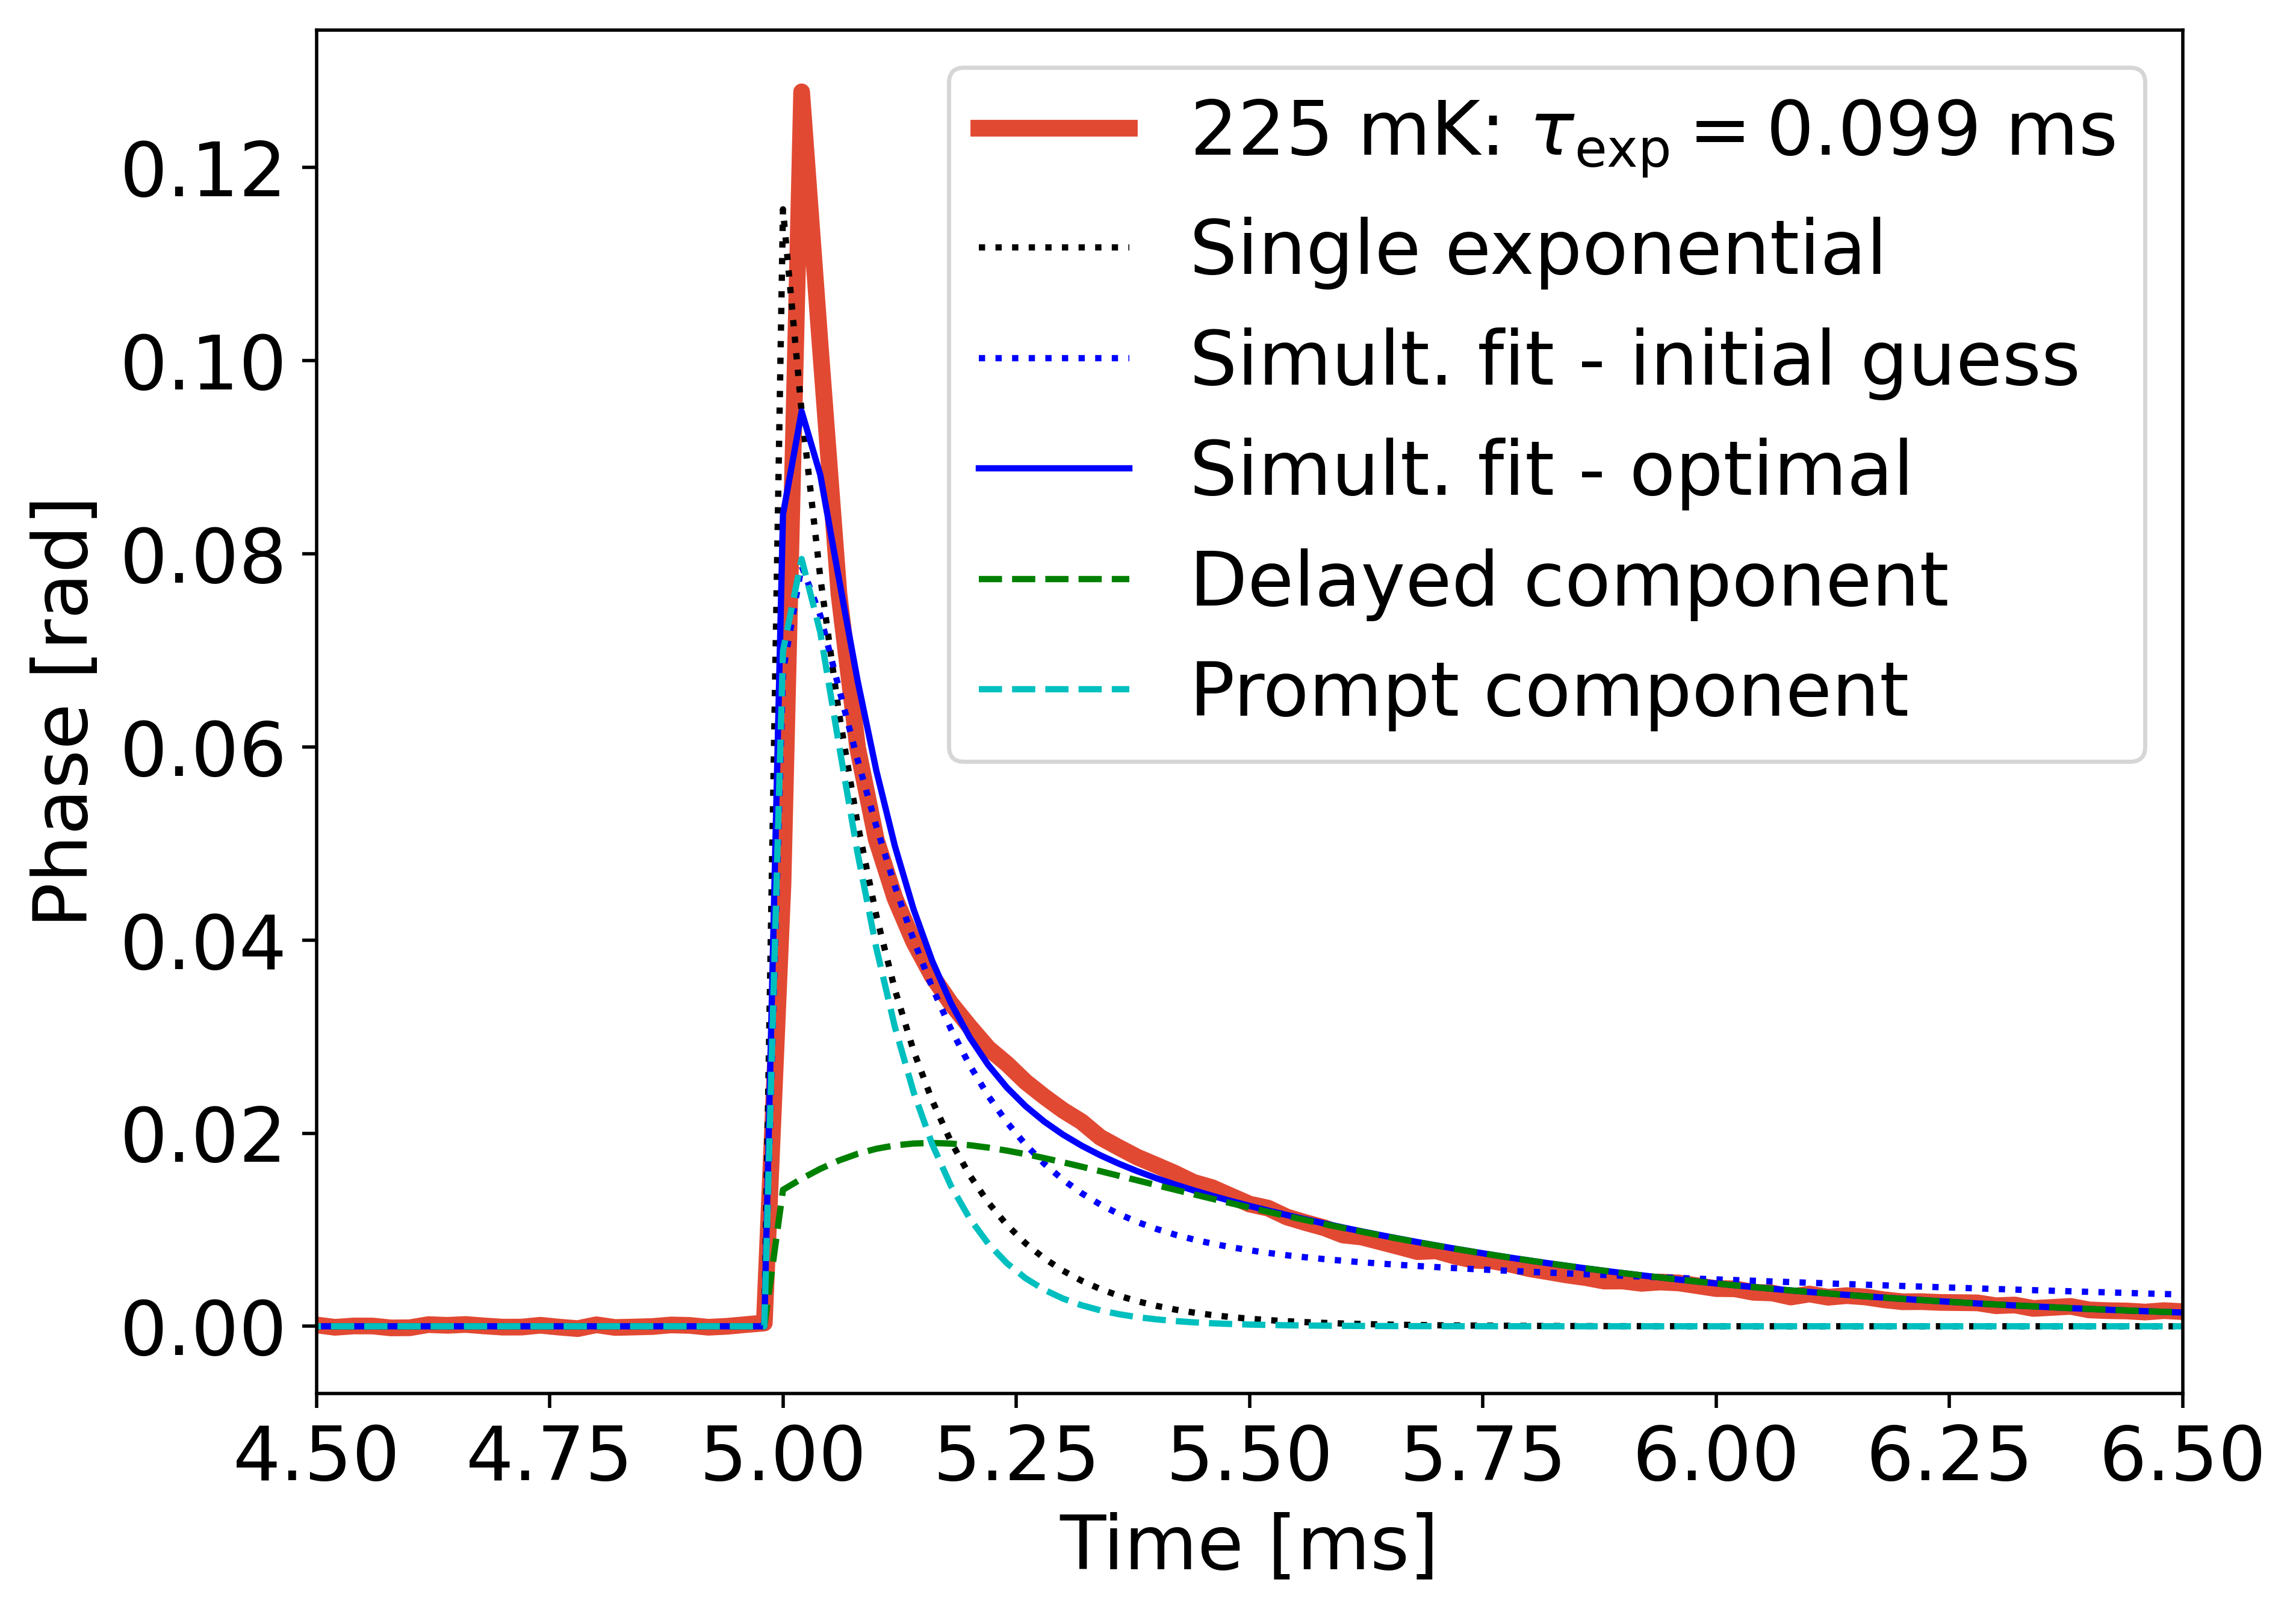

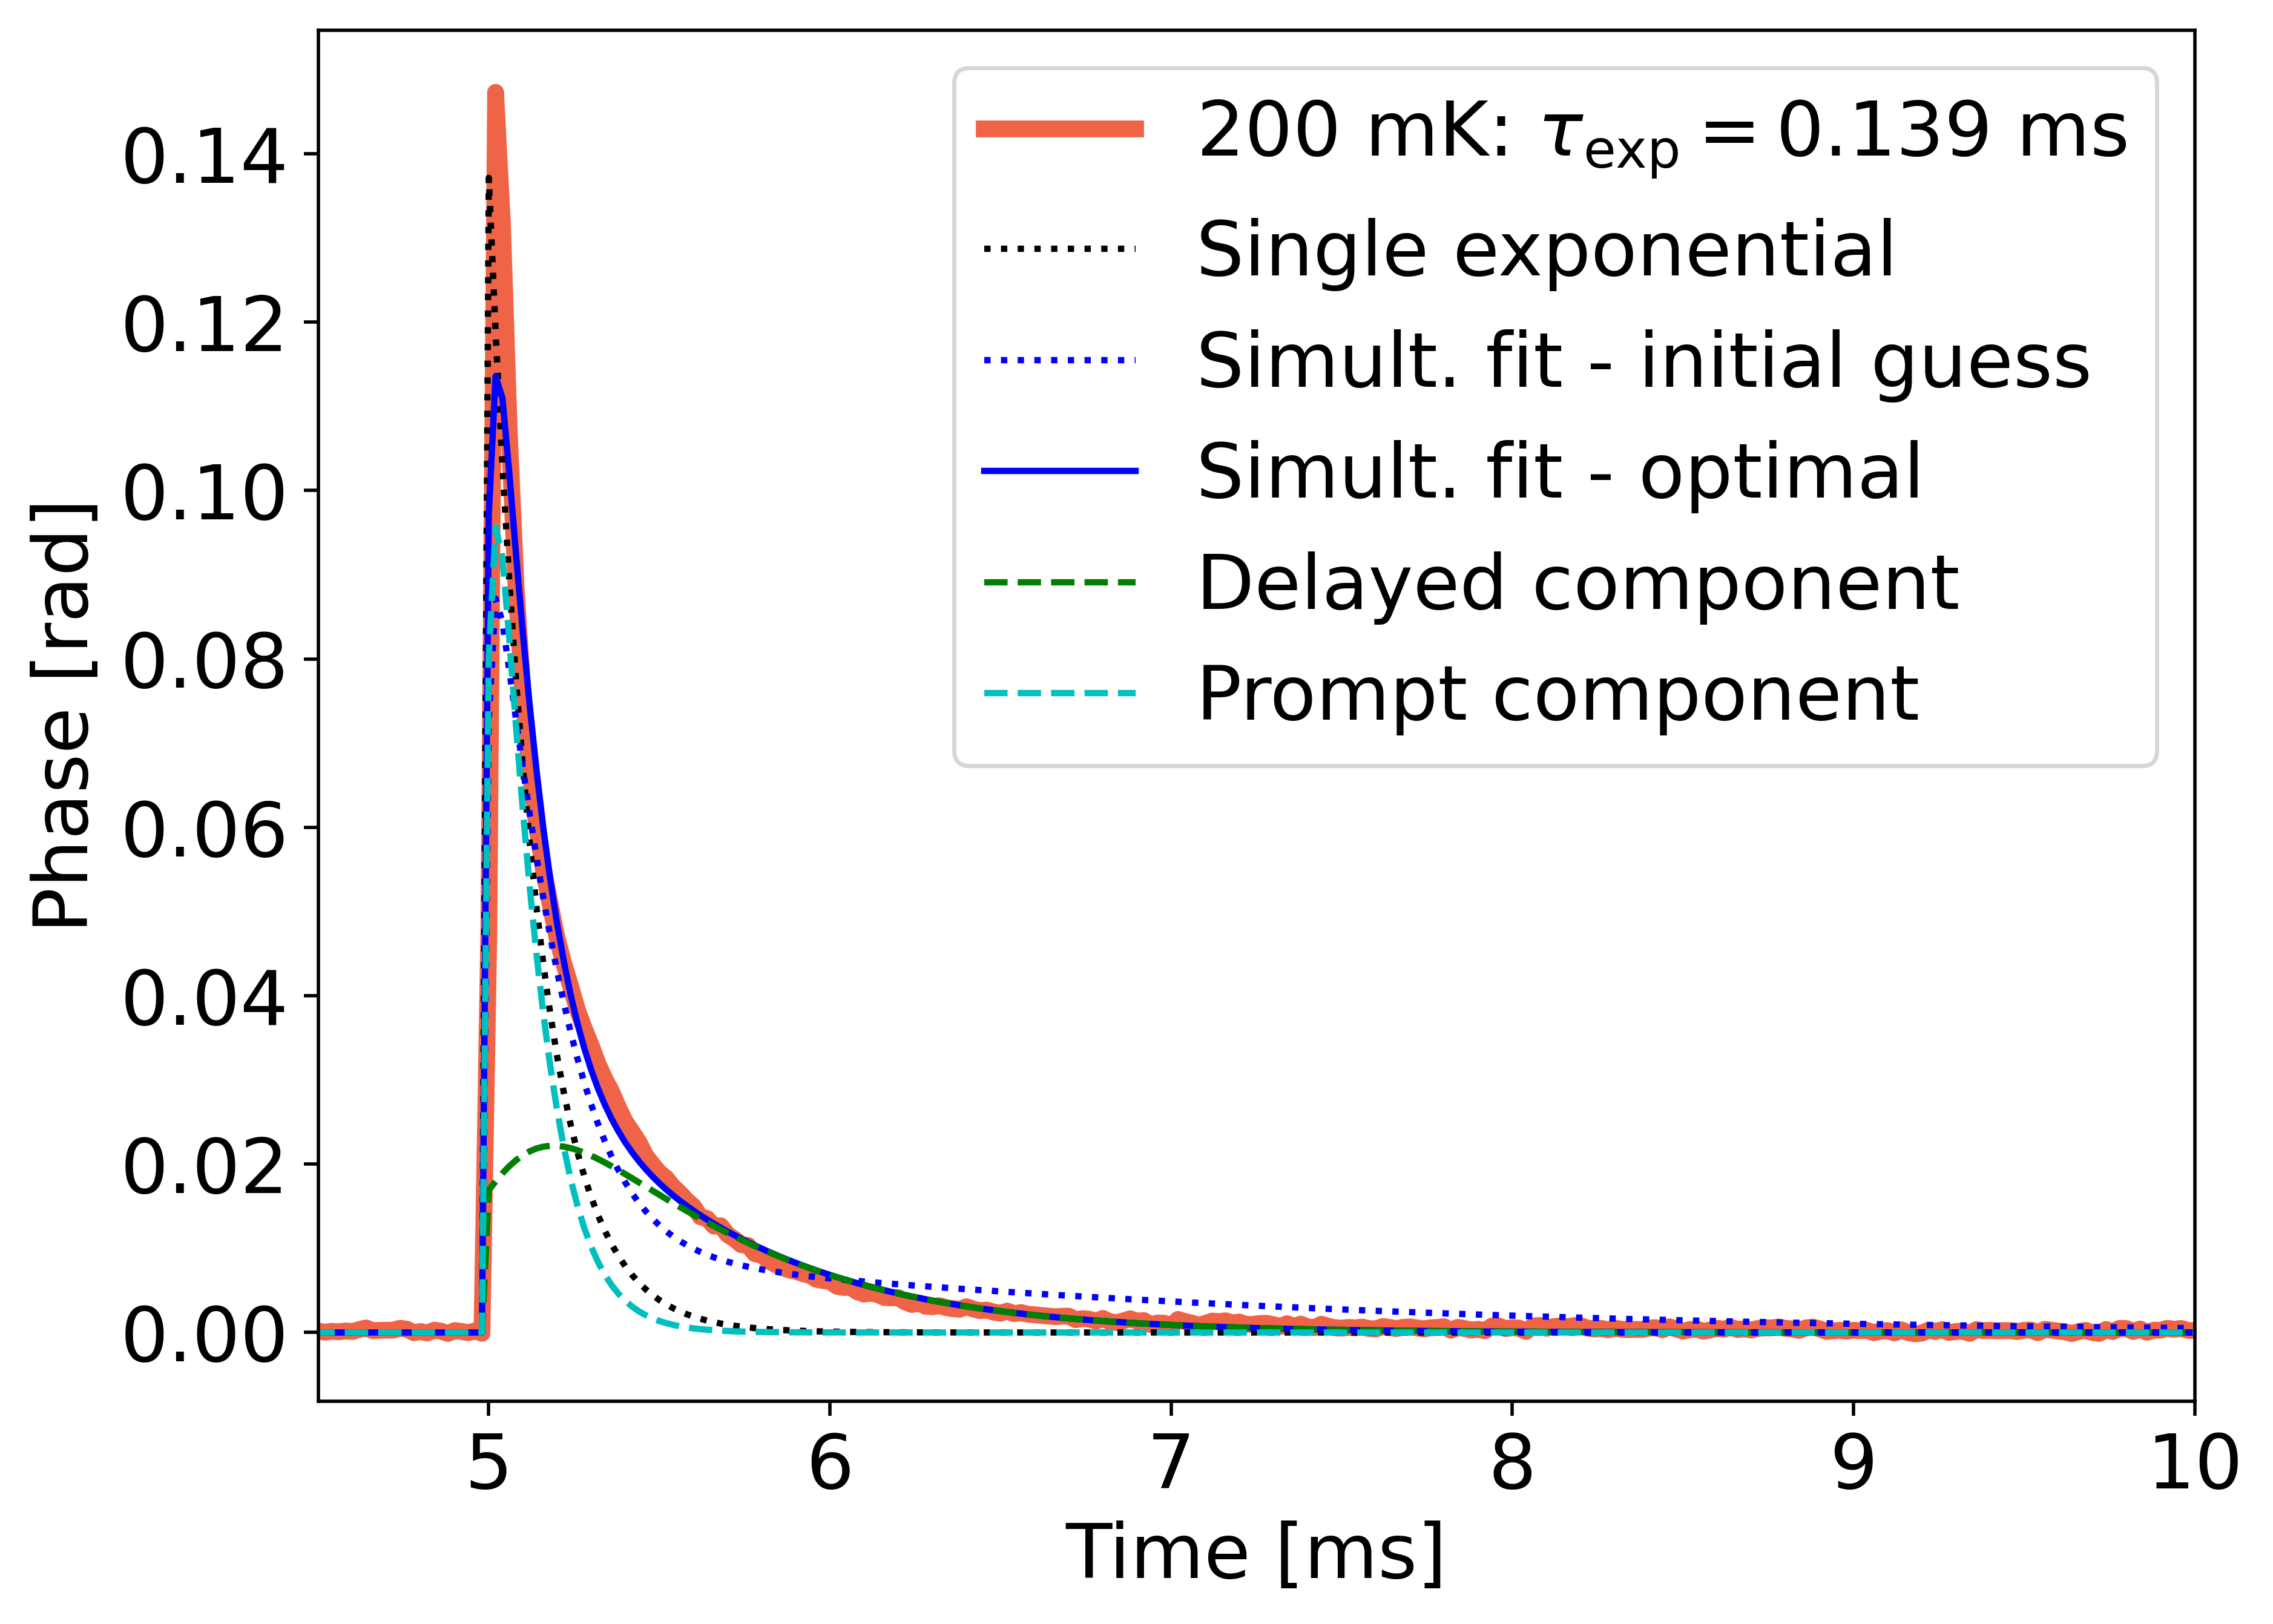

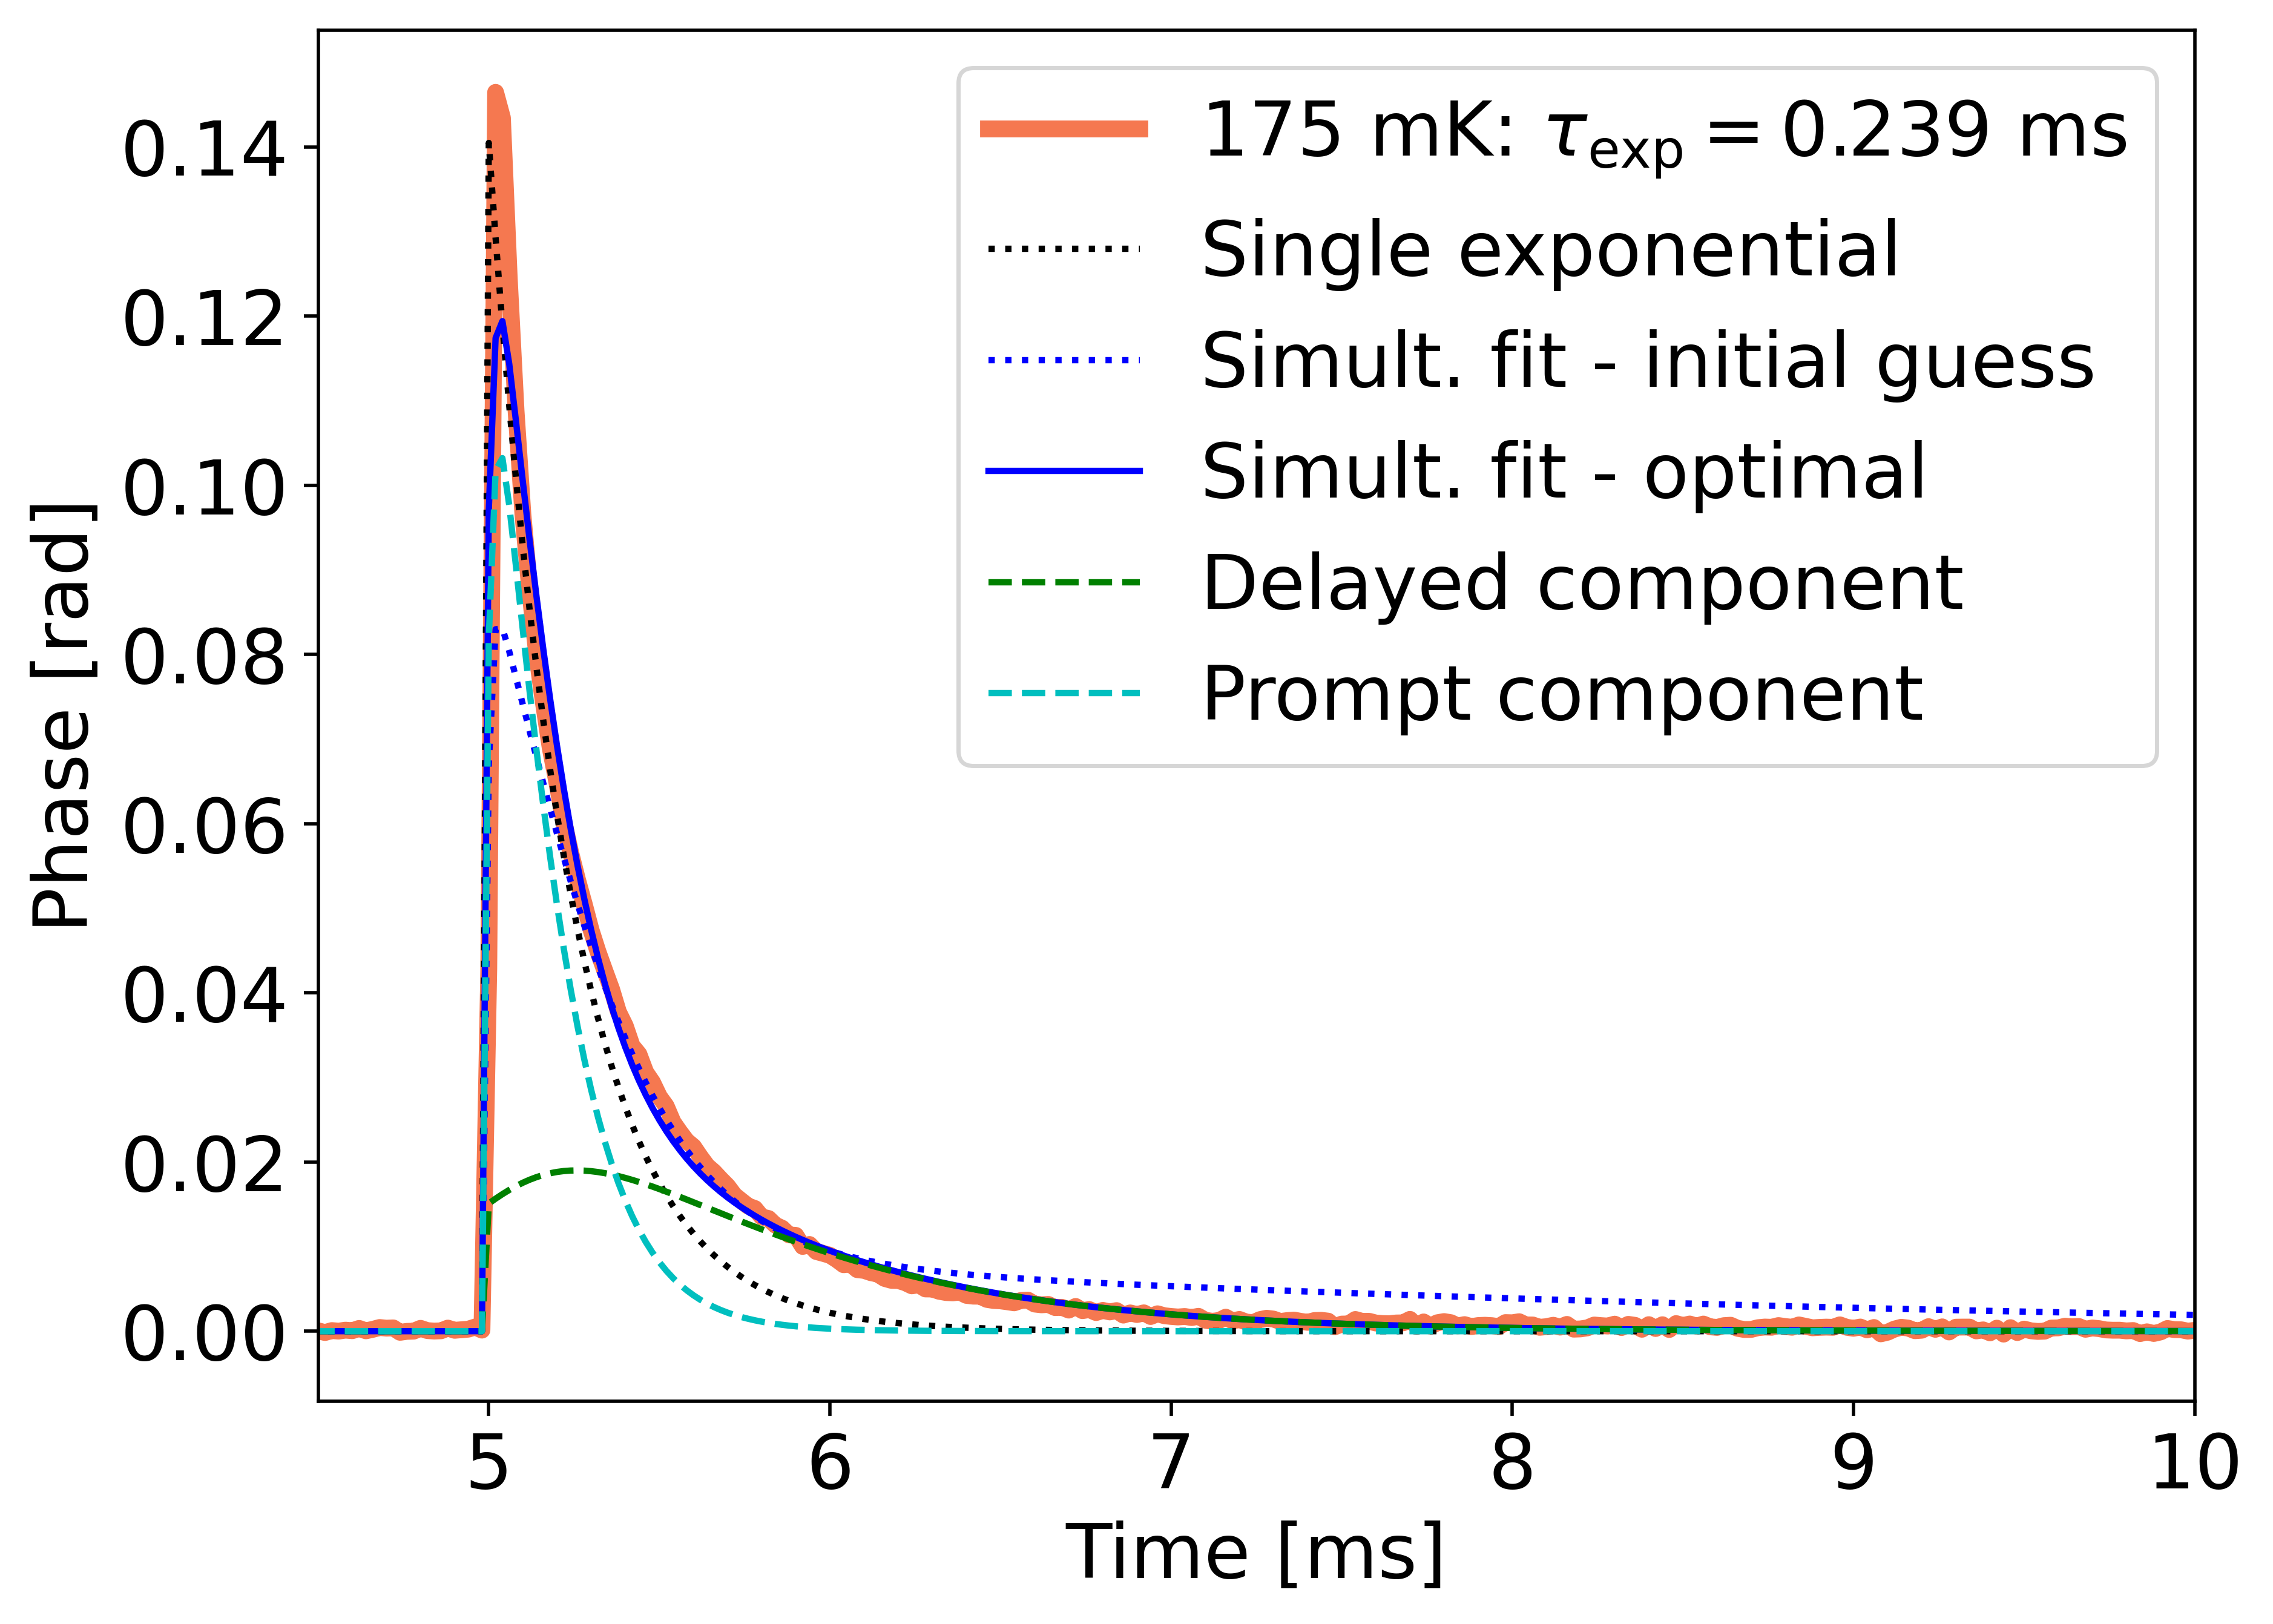

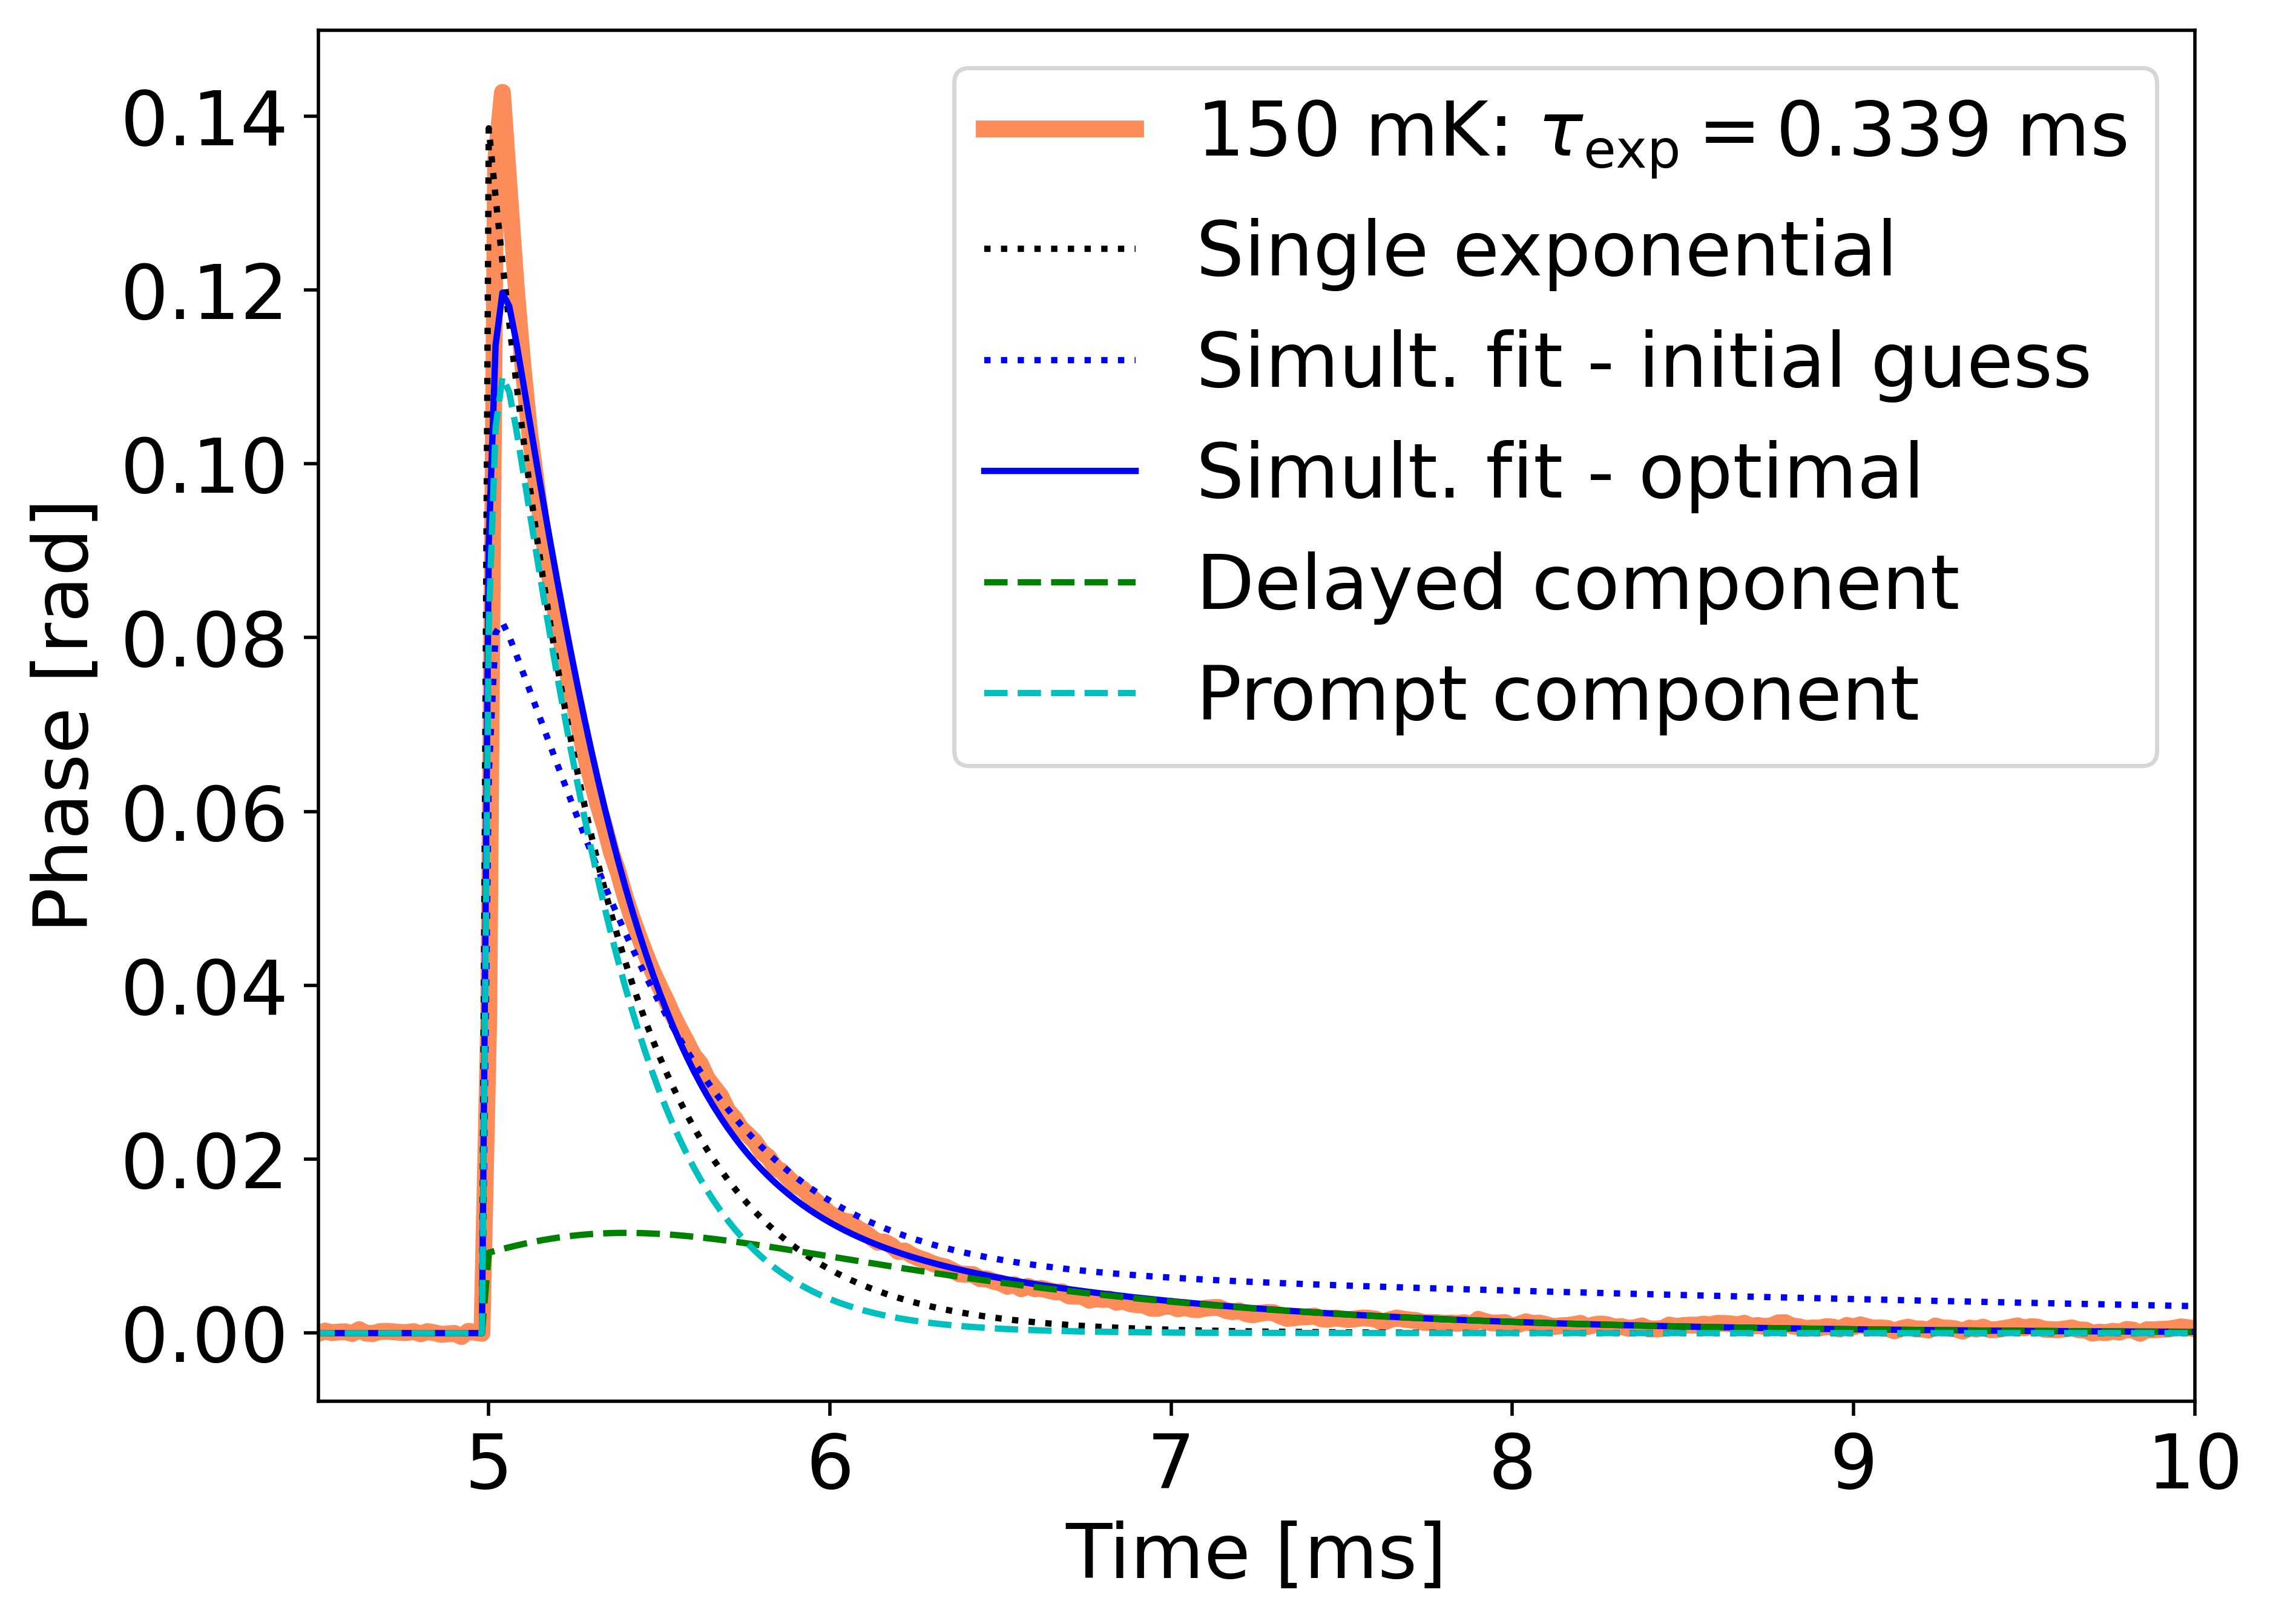

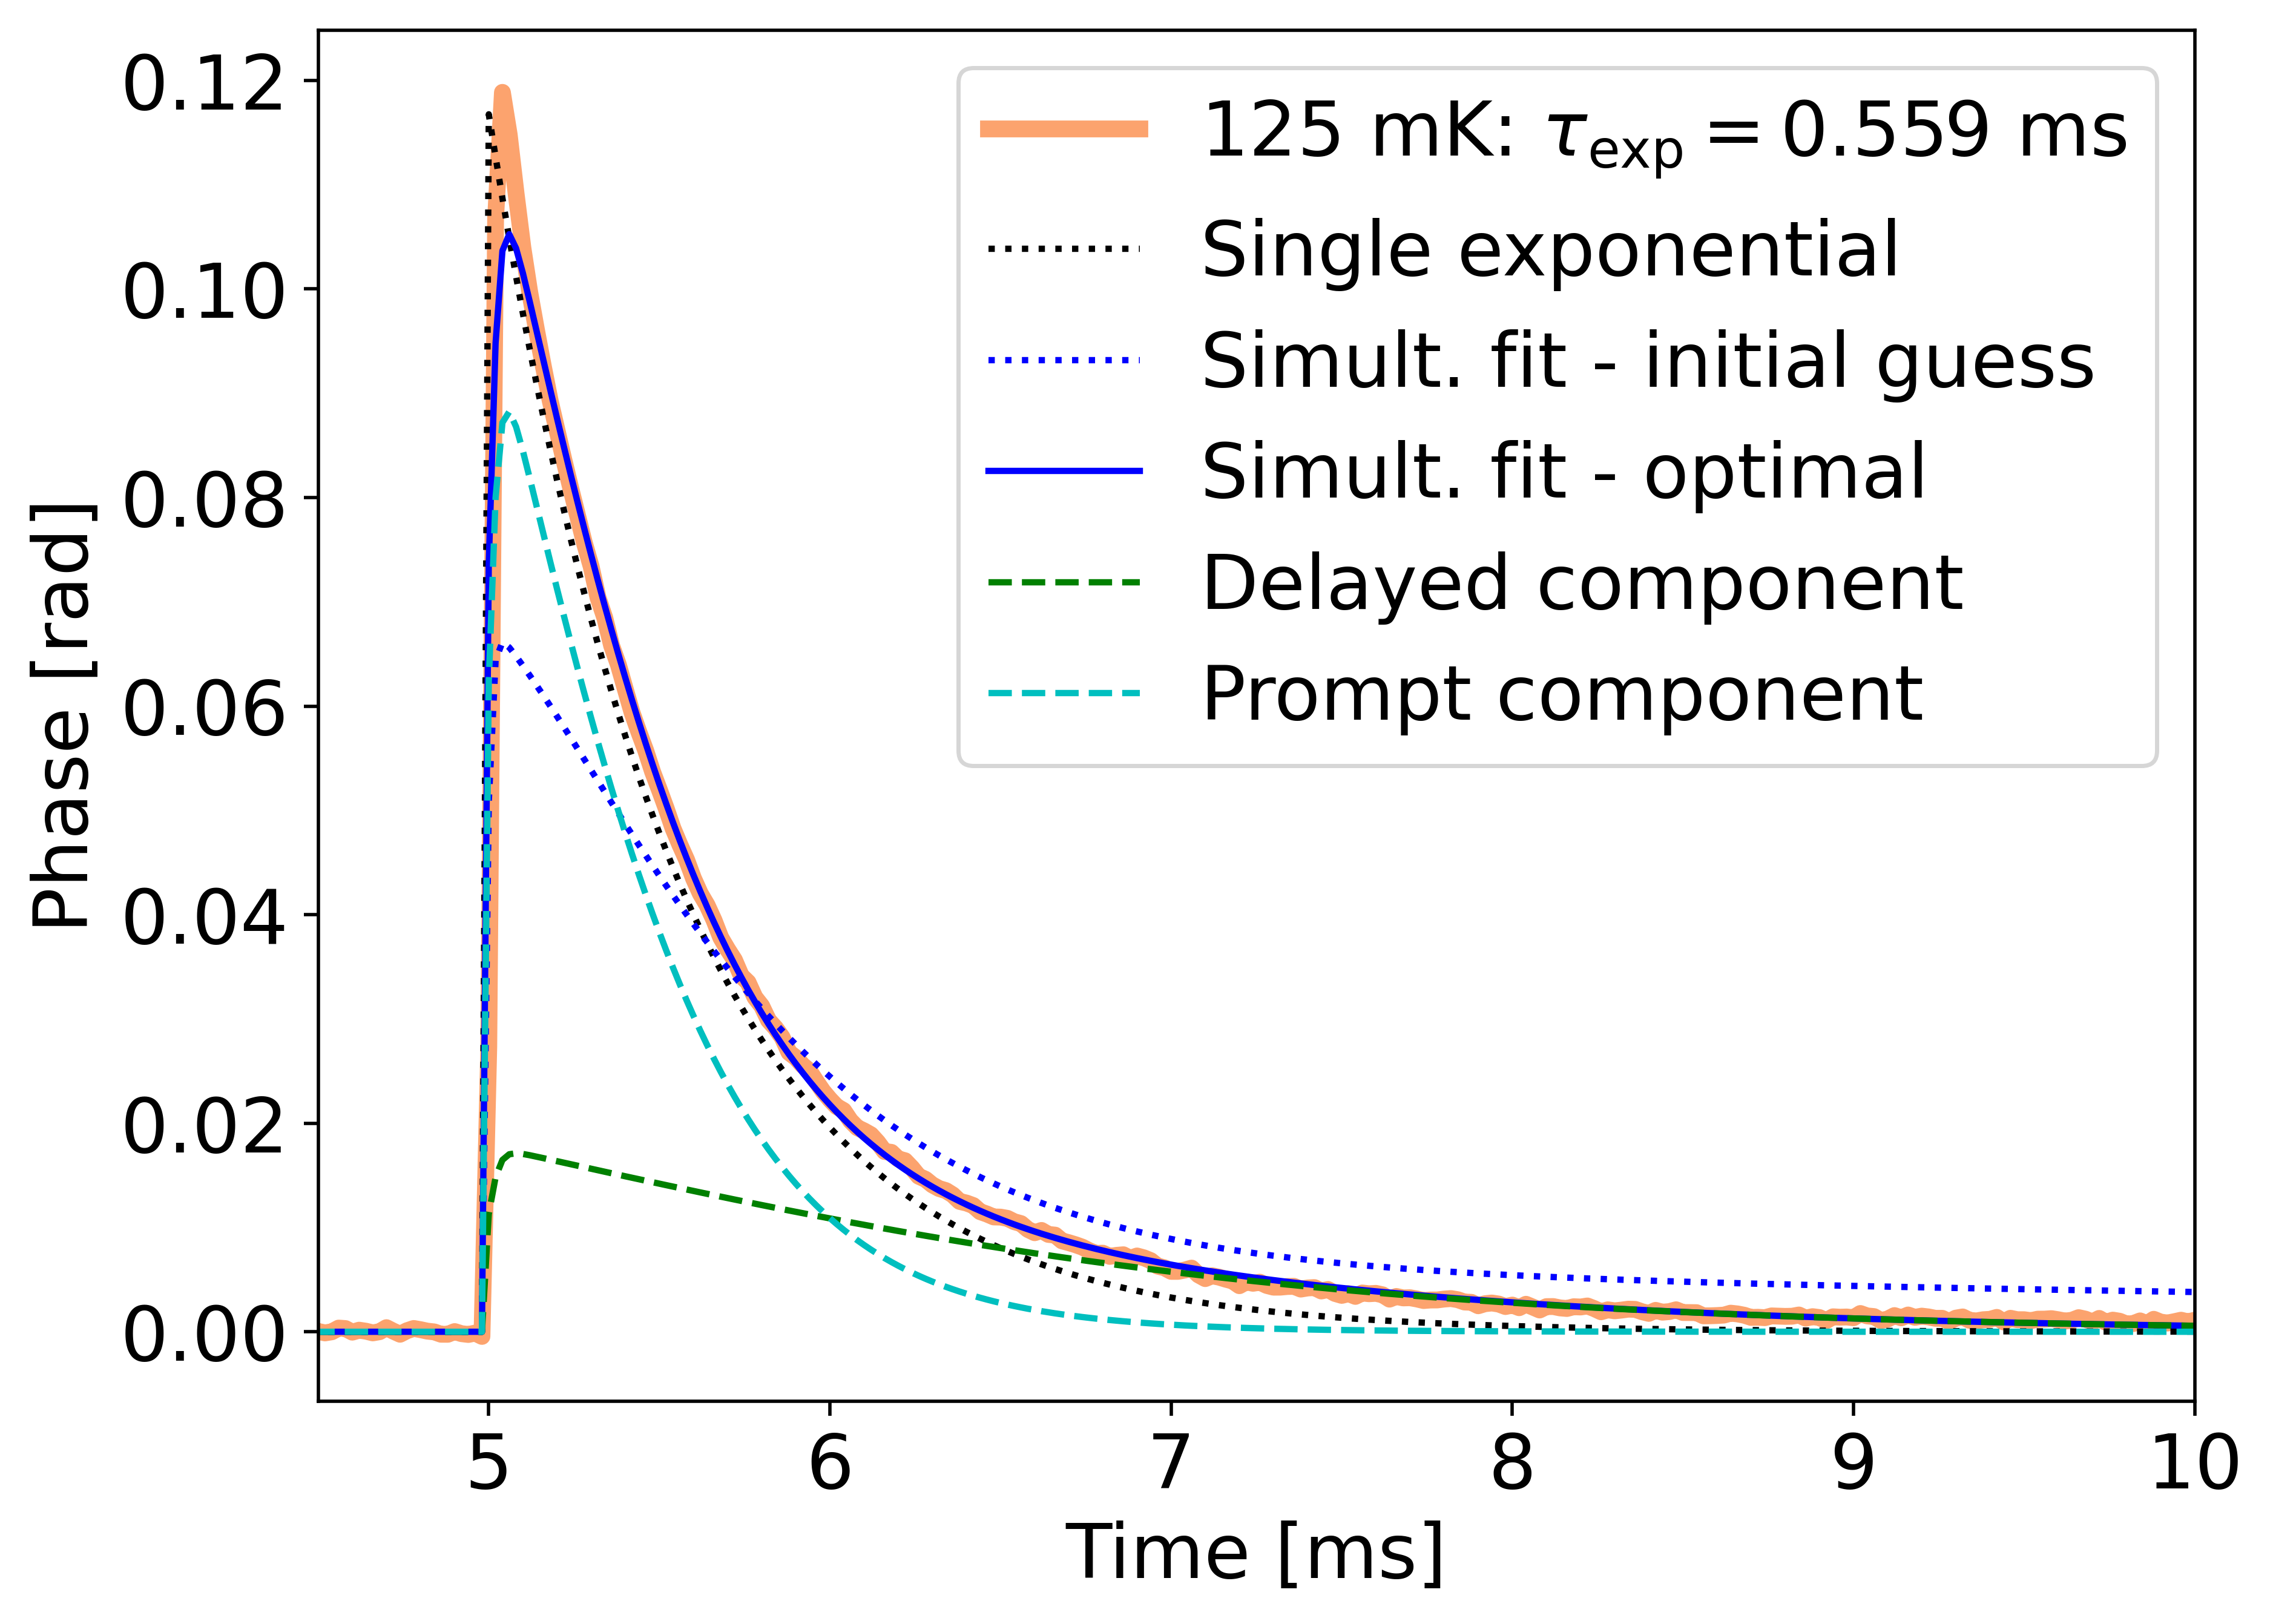

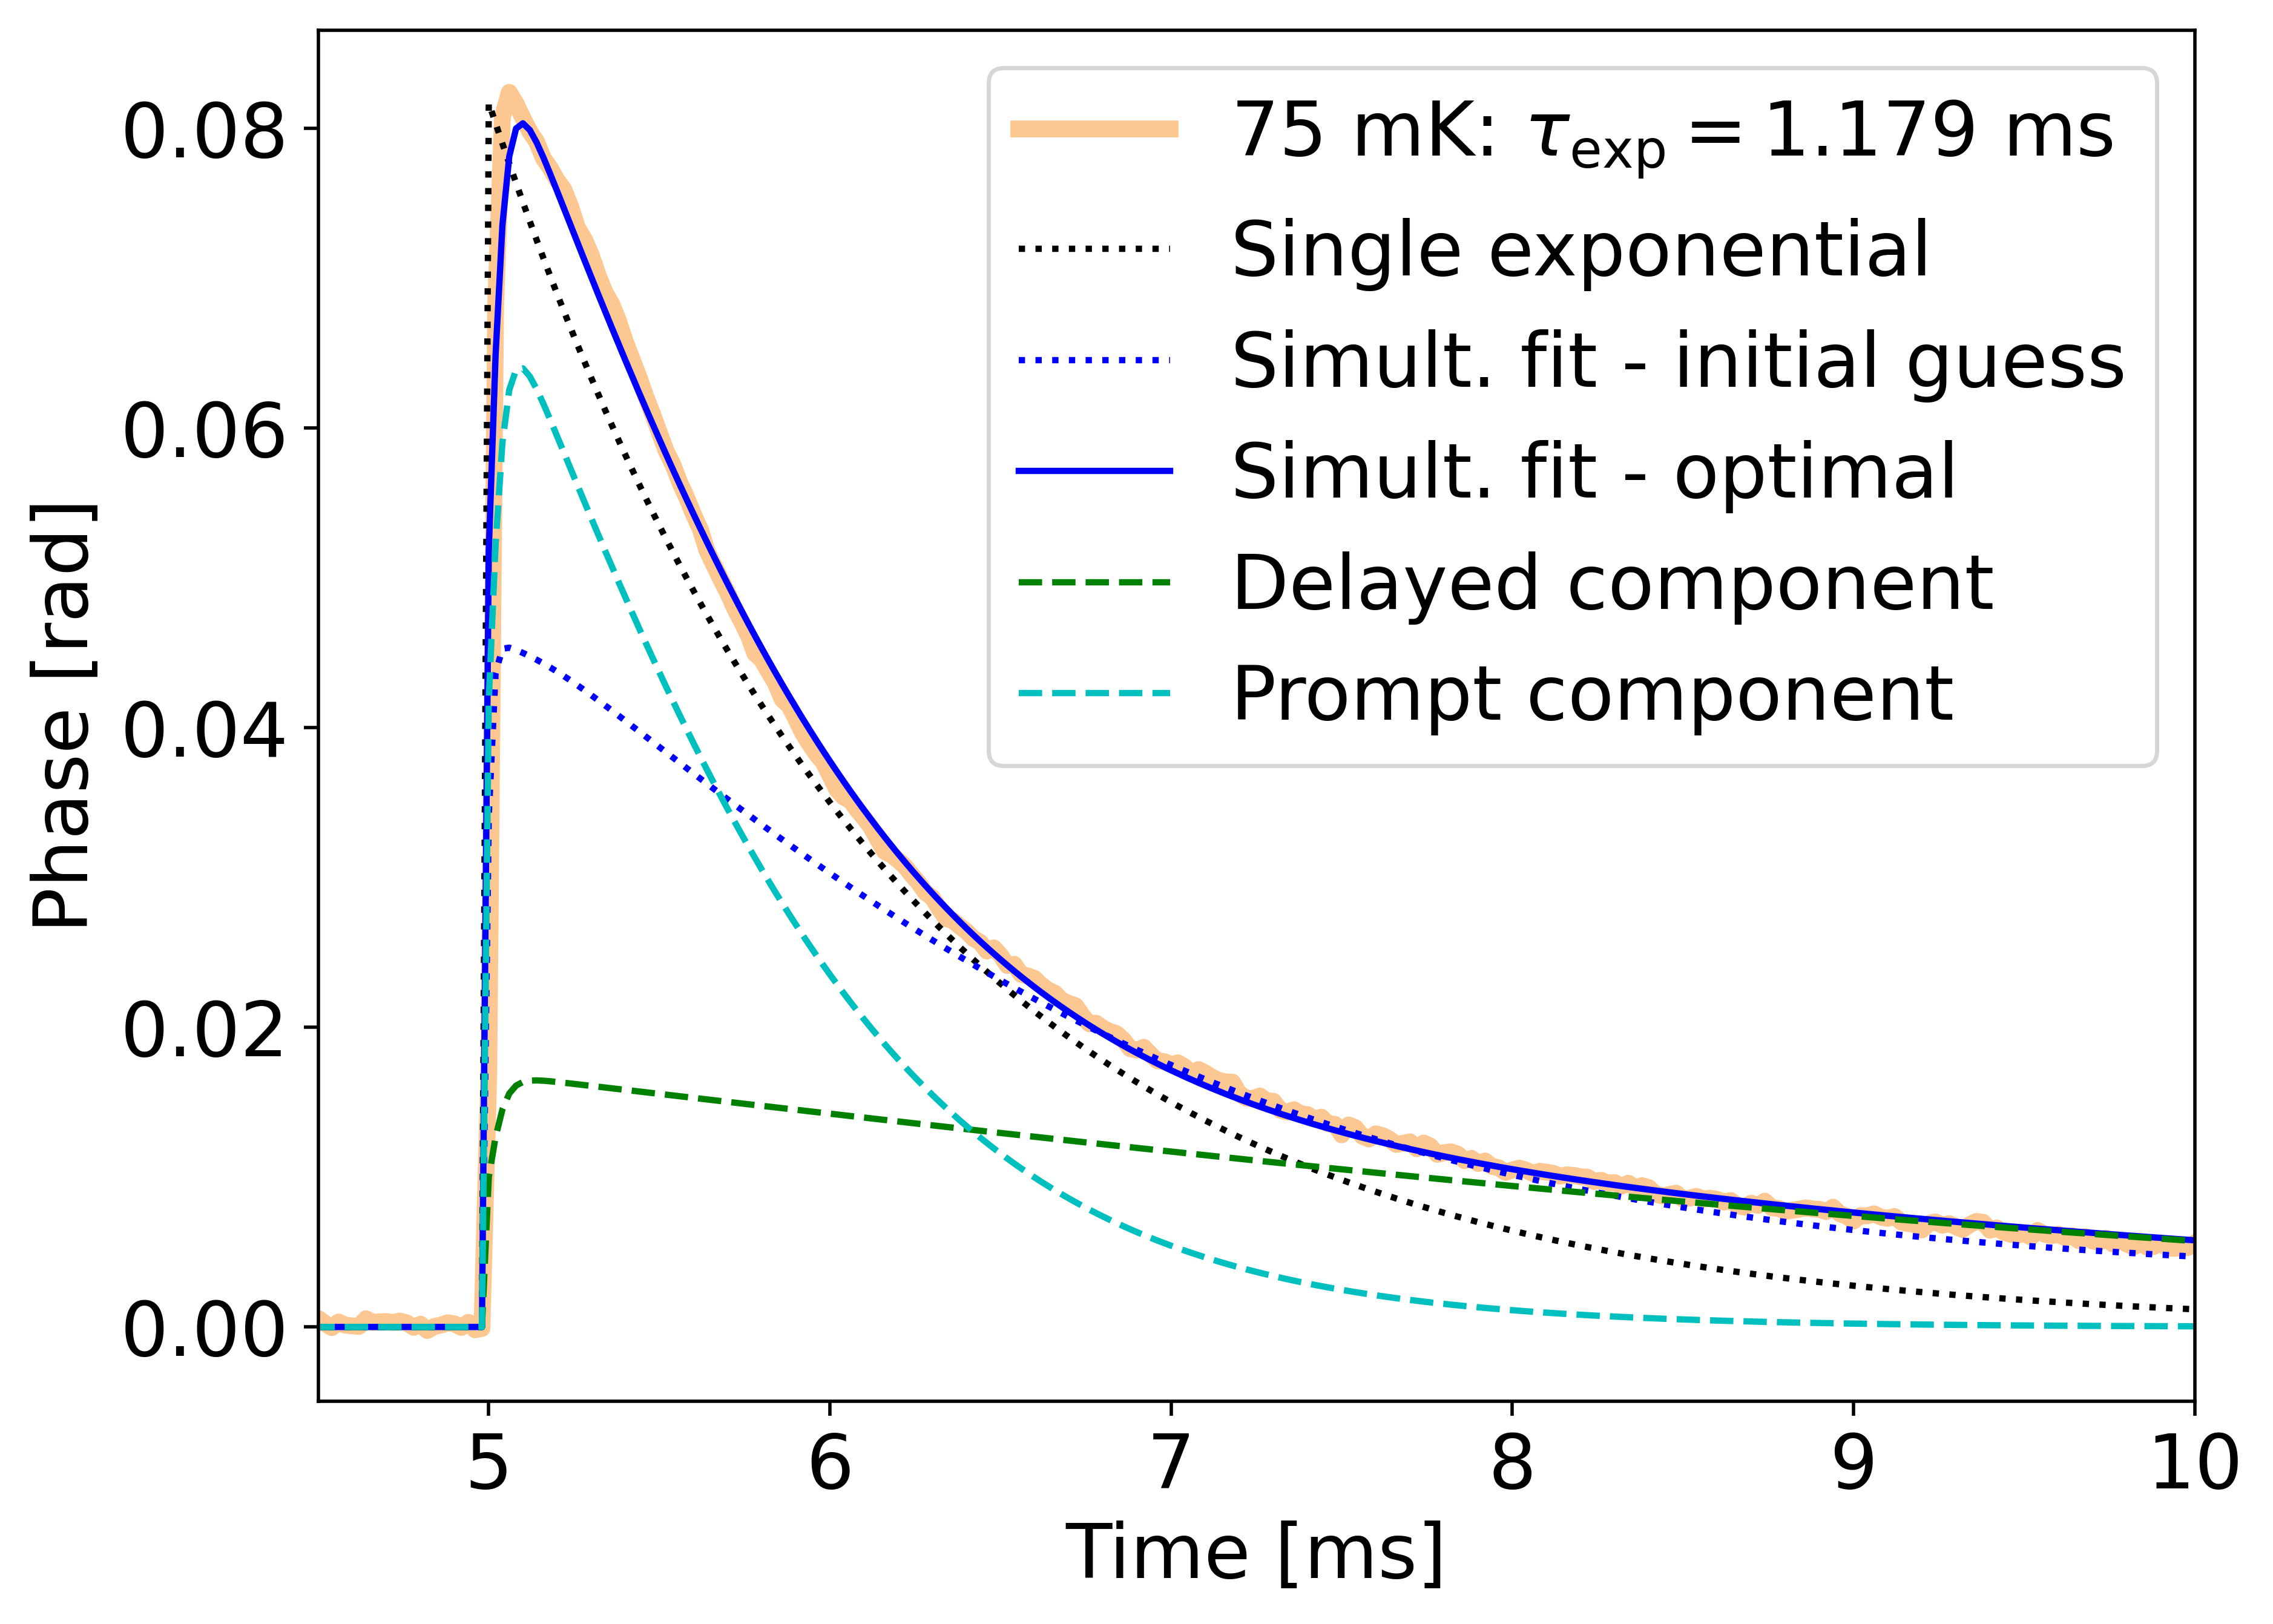

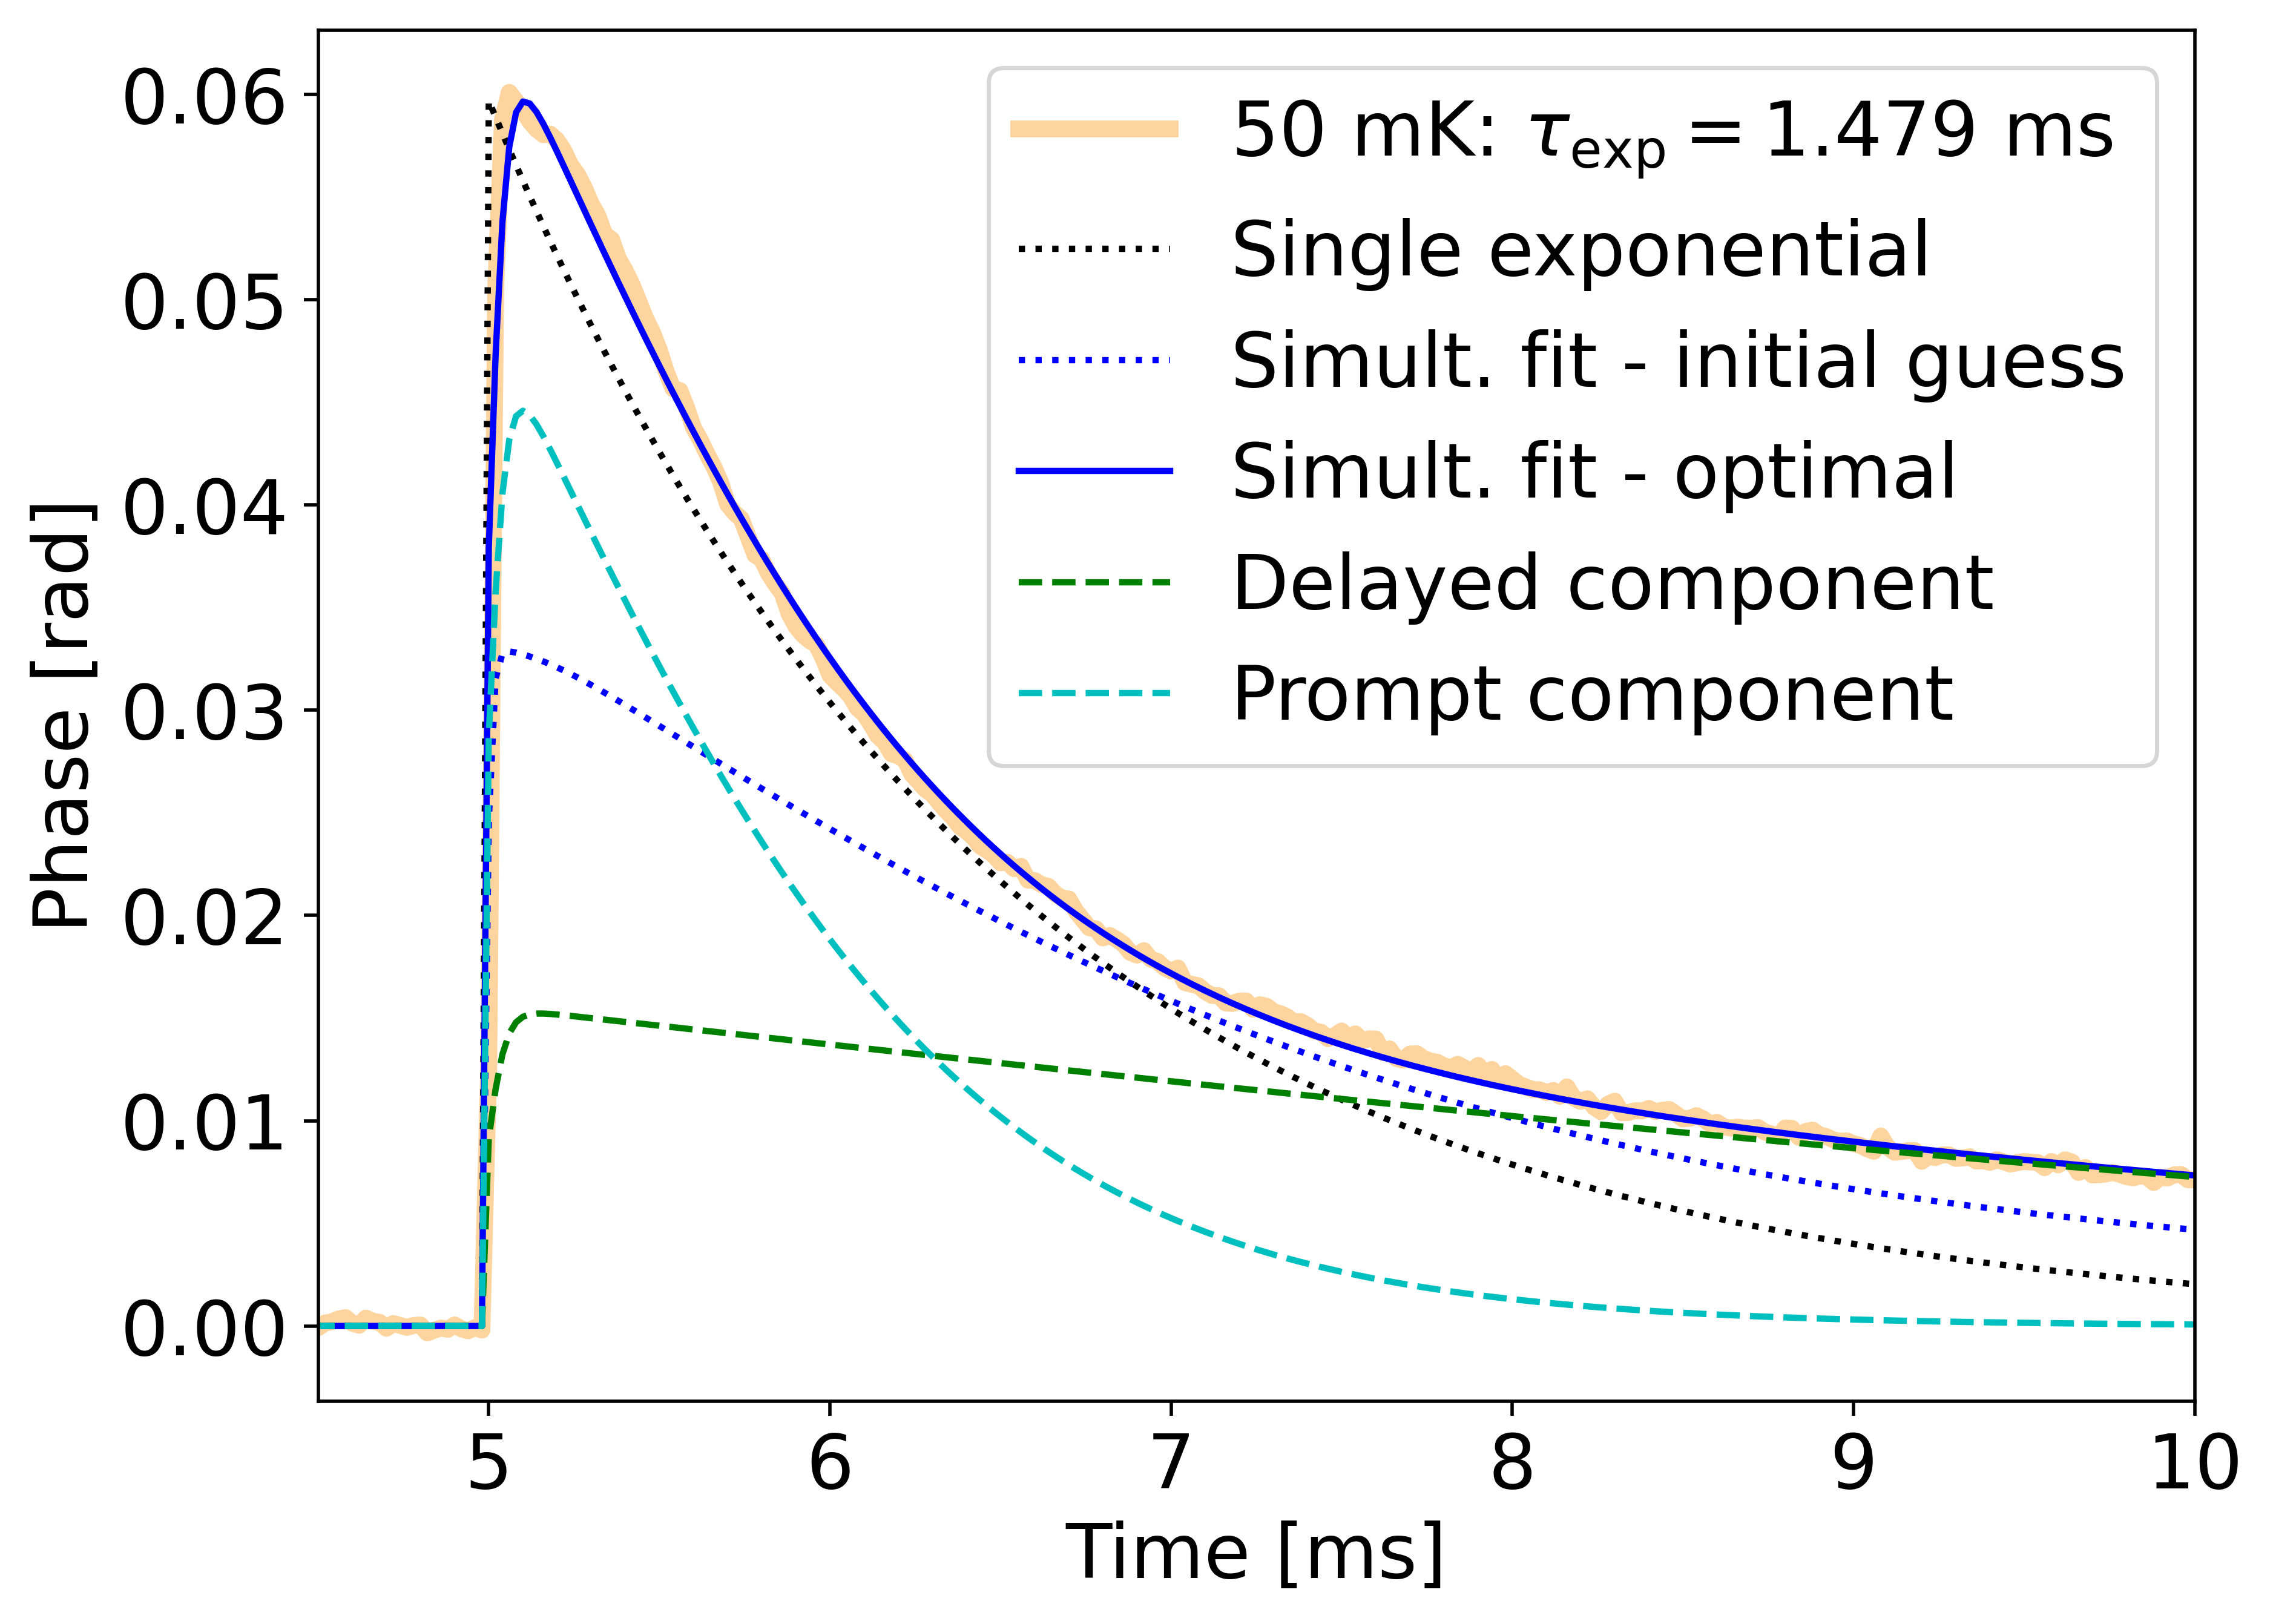

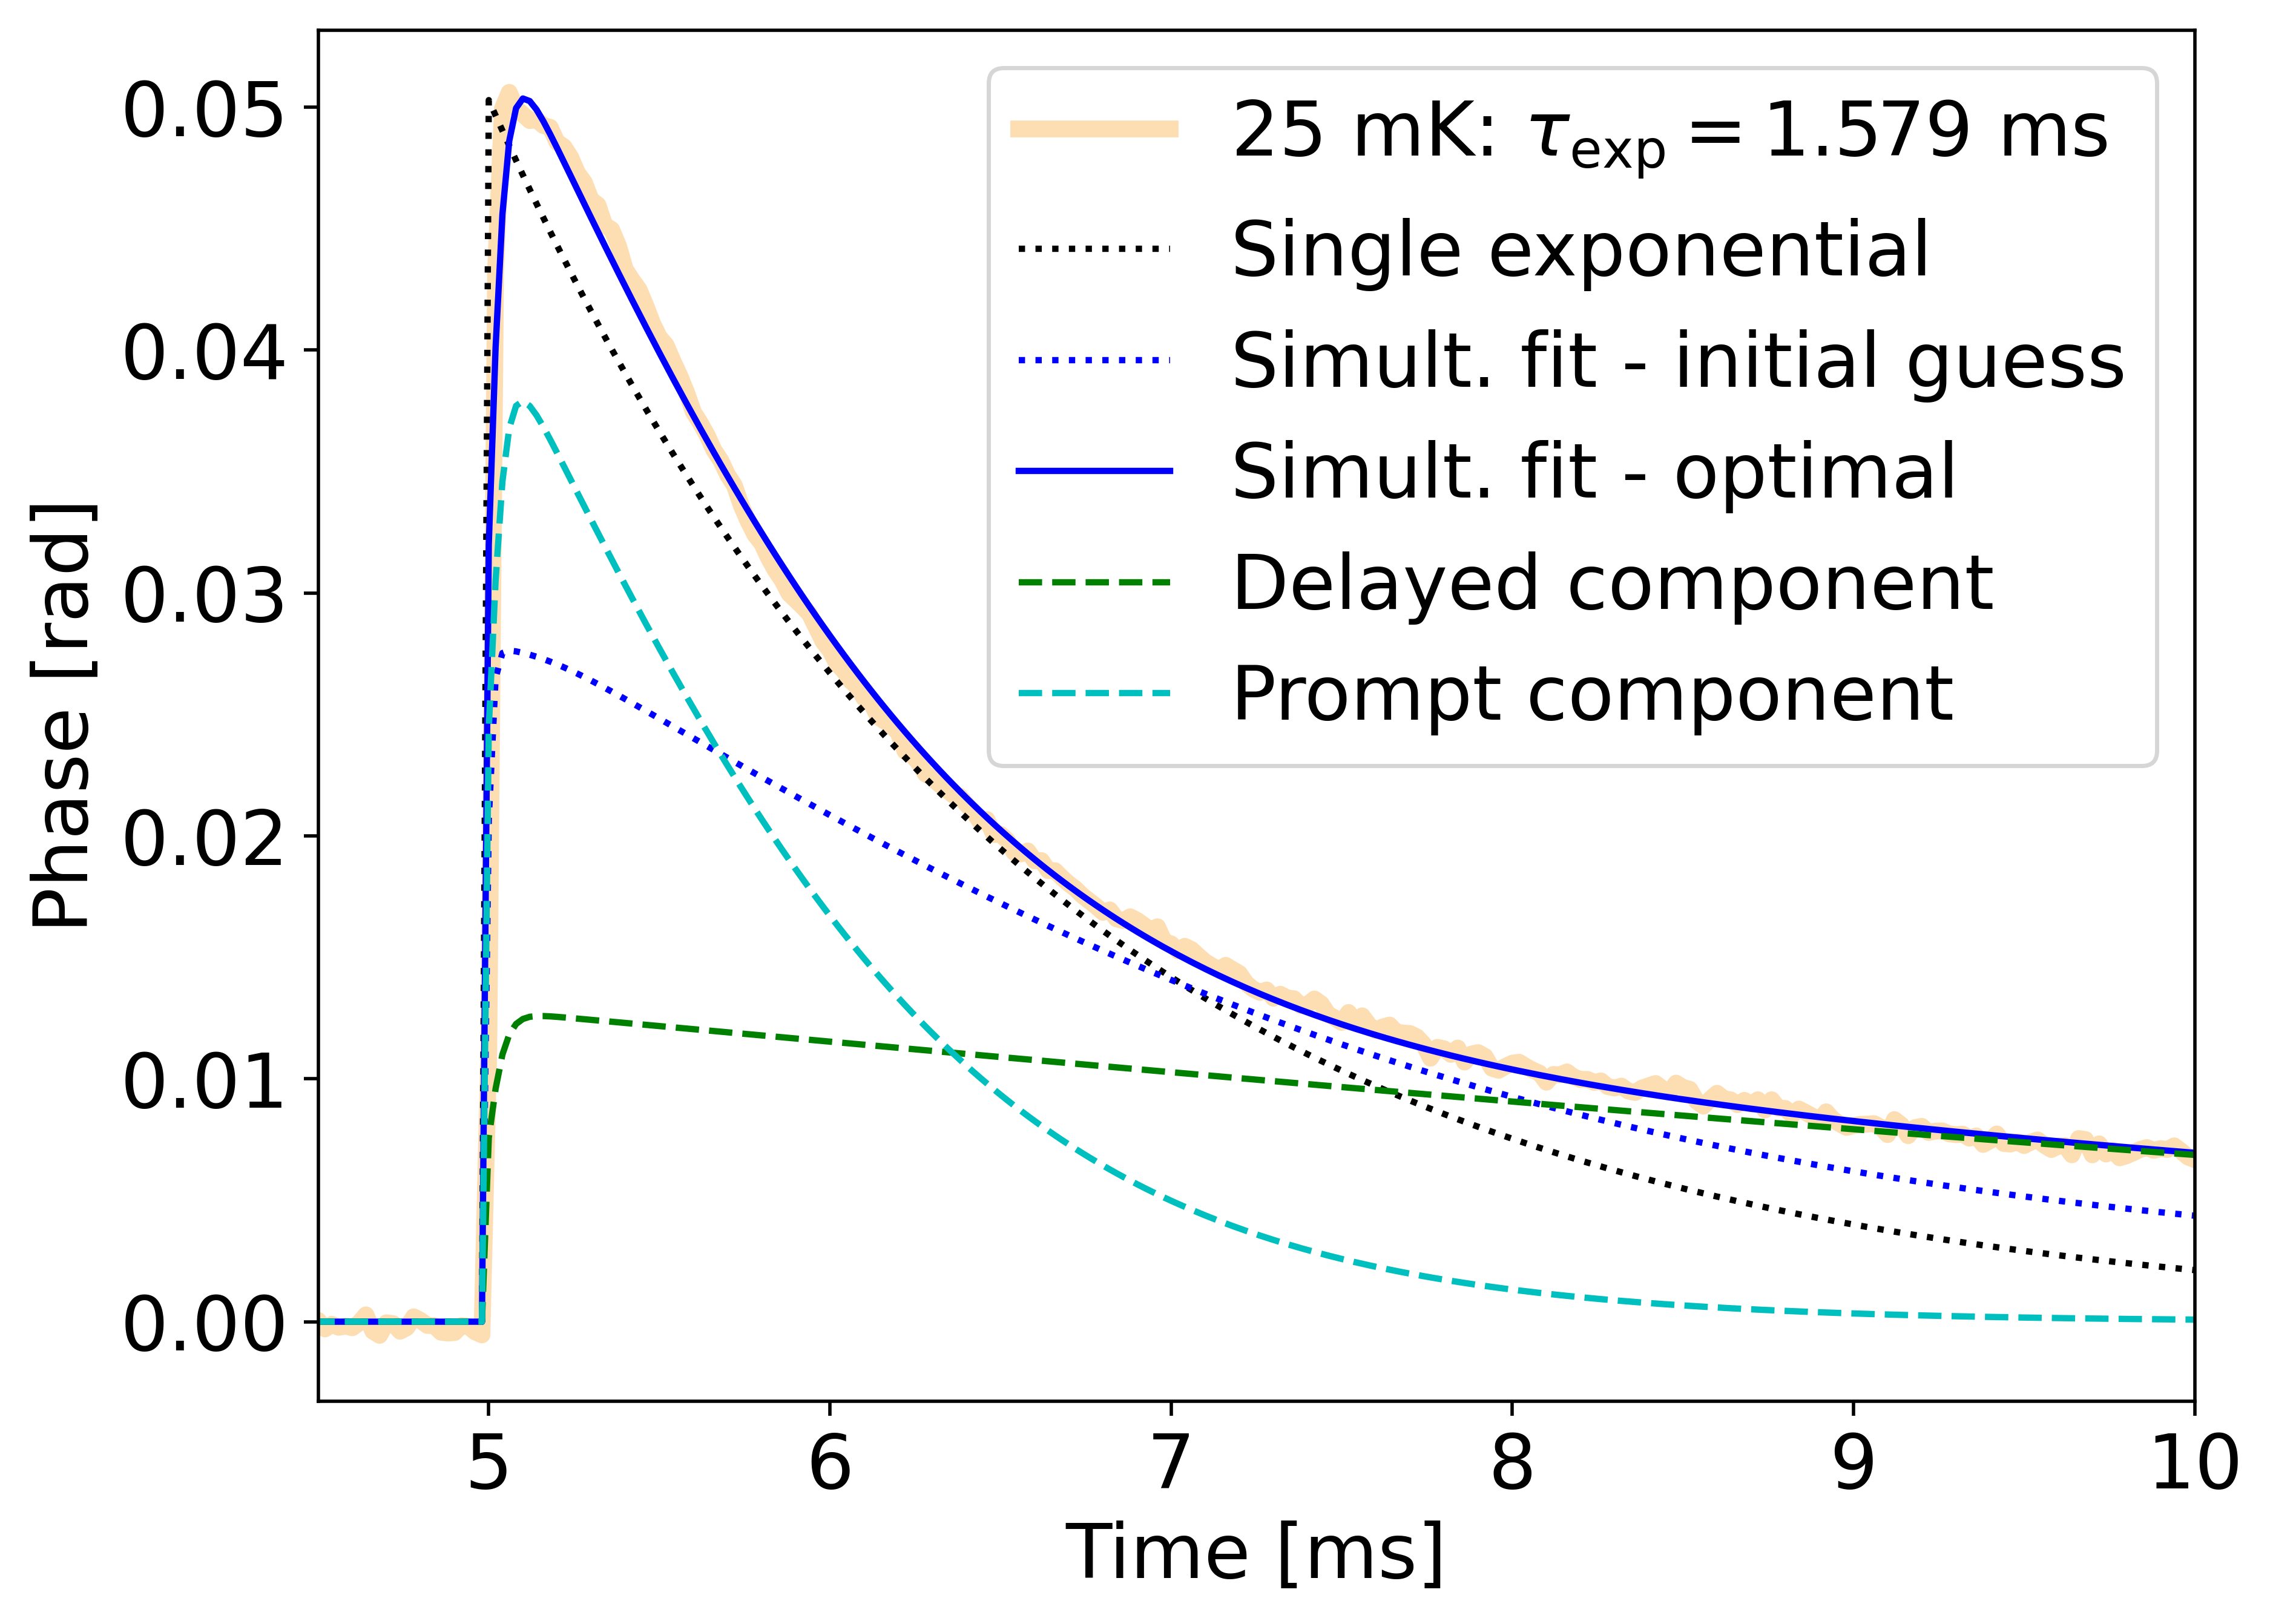

In [8]:
## Create a figure for all pulses
plt.figure("A",figsize=(10,8),dpi=500)
ax0 = plt.gca()
ax0.set_xlabel("Time [ms]")
ax0.set_ylabel("Phase [rad]")
ax0.set_title("Feedline RF Power: "+str(-30-line_atten_dB)+r" dBm; $V_\mathrm{LED}=$"+str(4.00))
cmap = plt.get_cmap('OrRd')
xlims = [4.5, 10.0]

## Initialize containers for our initial guesses
N_temps        = len(temps_mK)
lifetimes      = np.zeros(N_temps)
amplitudes     = np.zeros(N_temps)
prompt_fall_ms = np.zeros(N_temps)
delayd_fall_ms = np.zeros(N_temps)
pulse_max_phse = np.zeros(N_temps)

for i in np.arange(N_temps):
    k = data.keys()[1+i]
    print(k+ "mK----------")
    
    ## Get the color for this temperature
    color=cmap( (float(k)+50) / (np.max(temps_mK)+50) )
    
    ## Pull the averate pulse and time values
    t_vals = np.array(data["time(ms)"]) #- ts
    p_vals = np.array(data[k])
    
    #### === ==================== === ###
    
    ## Estimate the single exponential parameters
    param_est = pf.estimate_params(t_vals, p_vals, t_cutoff_ms=15.0, verbose=True)
    
    ## Save our calculated guesses for plotting later
    lifetimes[i]      = param_est["tau"]
    amplitudes[i]     = param_est["amp"]
    pulse_max_phse[i] = param_est["pmax"]
    
    ## Run the fit routine
    ## tp_guess (float): guess for time constant: prompt rise time
    ## td_guess (float): guess for time constant: delayed rise time
    ## kd_fac_guess (float): multiplicative factor of prompt fall time to guess delayed fall time
    ## ad_fac_guess (float): divisive factor of prompt amplitude (at t=0) to guess delayed amplitude
    p_guess, p_opt, p_cov = pf.run_fit(t_vals, p_vals, param_est, 
                                       tp_guess=0.01, td_guess=0.1, 
                                       kd_fac_guess=10.0, ad_fac_guess=10.0, 
                                       t_cutoff_ms=15.0)
        
    ## Get a curve for the best guess
    all_guess = pf.dbl_pls_shape(t_vals,p_guess[0],p_guess[1],p_guess[2],p_guess[3],p_guess[4],p_guess[5])
    
    ## Get a curve for the optimal shape
    all_pls   = pf.dbl_pls_shape(t_vals,p_opt[0],p_opt[1],p_opt[2],p_opt[3],p_opt[4],p_opt[5])
        
    ## Save our optimal parameters for plotting later
    prompt_fall_ms[i] = p_opt[5]
    delayd_fall_ms[i] = p_opt[2]
    
    #### === ==================== === ###
    
    ## Add the average pulse to the to the plot of all temperatures
    ax0.plot( t_vals, p_vals, label=k+r" mK" , color=color)
    
    ## Create a new plot for each individual temperature
    plt.figure(str(i)+"B",figsize=(8,6),dpi=500)
    ax1 = plt.gca()
    ax1.set_xlabel("Time [ms]")
    ax1.set_ylabel("Phase [rad]")
    
    ## Plot the pulse
    ax1.plot( t_vals, p_vals, label=k+r" mK: $\tau_\mathrm{exp}=$"+str(int(lifetimes[i]*1e3)/1000.)+" ms", color=color, linewidth=4)
    ylims = ax1.get_ylim()
    
    ## Draw the single exponential guess
    ax1.plot( t_vals, pf.exp_fit(t_vals,amplitudes[i],lifetimes[i]), 'k:', label='Single exponential')
    
    ## Draw the overall shape
    ax1.plot( t_vals, all_guess, 'b:', label="Simult. fit - initial guess")
    ax1.plot( t_vals, all_pls  , 'b-', label="Simult. fit - optimal")
    
    ## Draw the prompt and delayed components' individual shapes
    ax1.plot( t_vals, pf.double_exp(t_vals,p_opt[0],p_opt[1],p_opt[2]), 'g--', label="Delayed component")
    ax1.plot( t_vals, pf.double_exp(t_vals,p_opt[3],p_opt[4],p_opt[5]), 'c--', label="Prompt component")
    
    ## Finalize the axes
    # ax1.set_ylim(ylims)
    ax1.set_xlim(xlims if float(k)<201.0 else [xlims[0],6.5])#10.0])
    ax1.legend()
    
ax0.legend()
ax0.set_xlim([xlims[0],10.0])

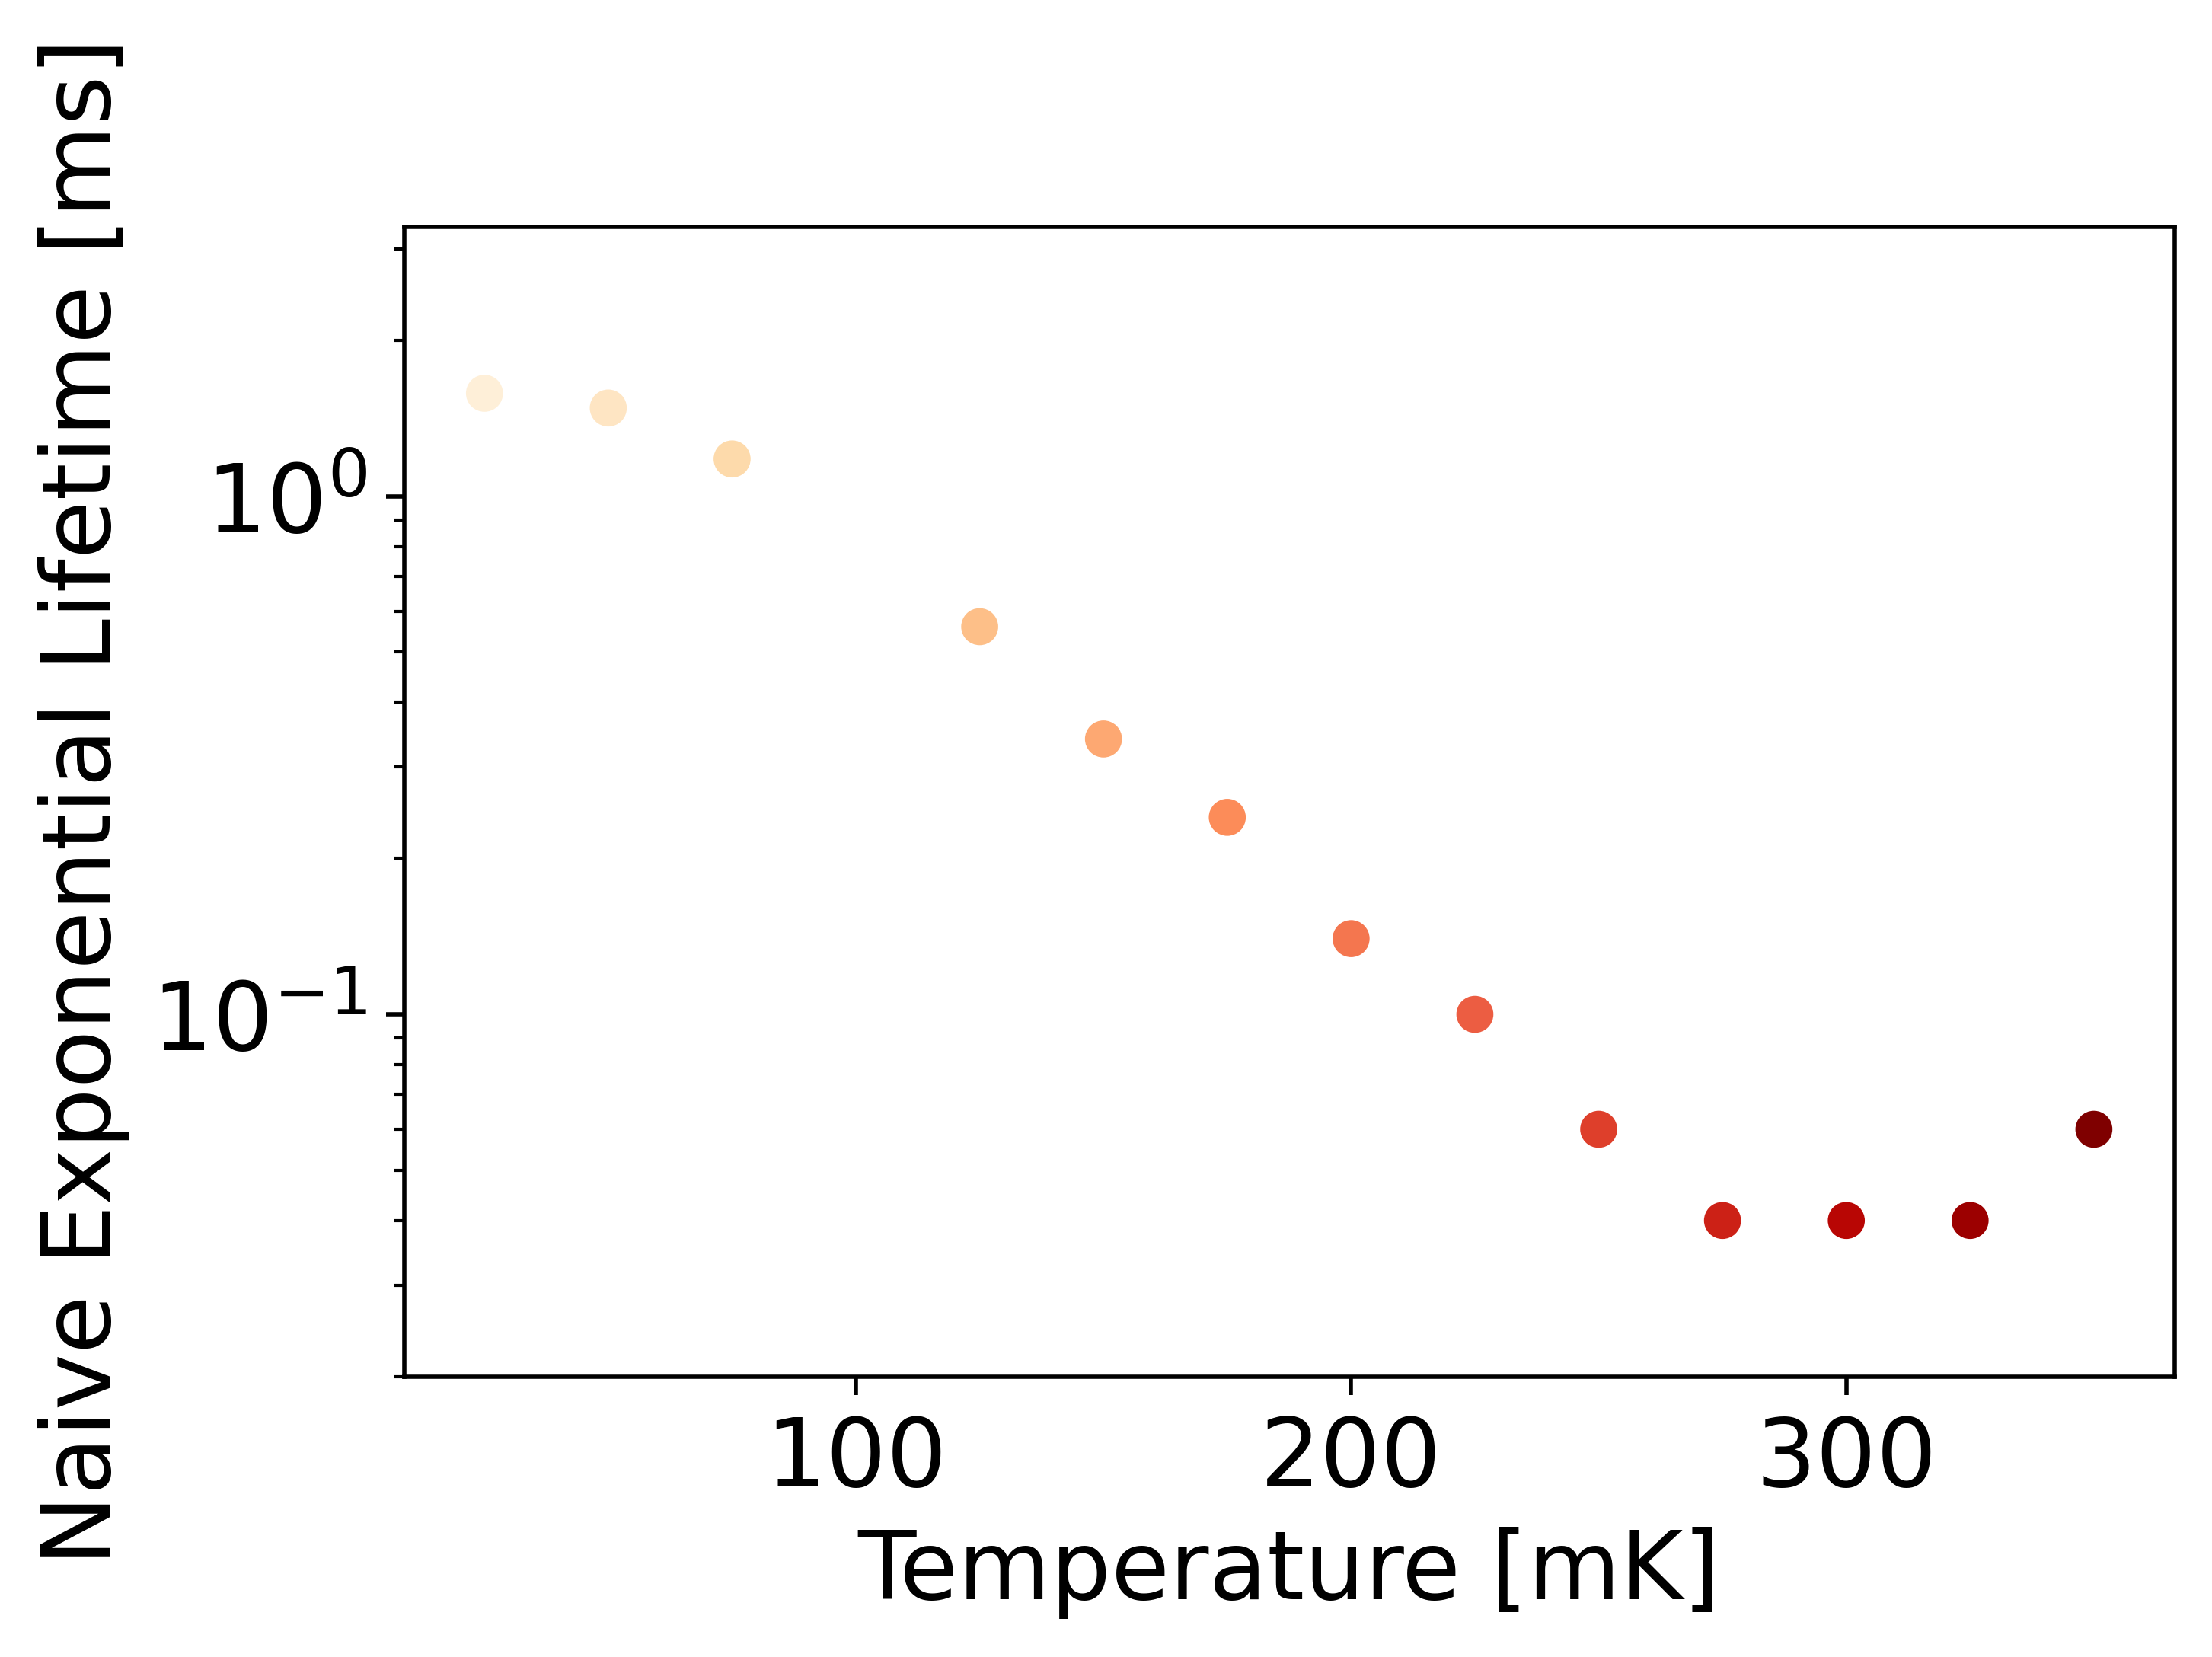

In [9]:
ax = plt.figure(dpi=500).gca()
ax.scatter(temps_mK,lifetimes,c=cmap( temps_mK / np.max(temps_mK) ))
ax.set_xlabel("Temperature [mK]")
ax.set_ylabel("Naive Exponential Lifetime [ms]")
if True:
    ylims = ax.get_ylim()
    ax.set_ylim([0.5*np.min(lifetimes[lifetimes>0]) , 2*ylims[1]])
    ax.set_yscale('log')

In [10]:
kB    = 8.617333262e-5 ## eV/K
Delta = 184e-6 ## eV
tau0  = 438.0e-9 ## sec -- from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.14.4854
Tc    = 1.19 ## K -- from https://journals.aps.org/prb/abstract/10.1103/PhysRevB.14.4854
def theory_curve(T_K,Tc_K,delta_eV,tau0_s):
    return ( (tau0_s/np.sqrt(np.pi)) * 
            np.power(kB*Tc_K/(2*delta_eV),5./2.) * 
            np.sqrt(Tc_K/T_K) * 
            np.exp(delta_eV/(kB*T_K)) )

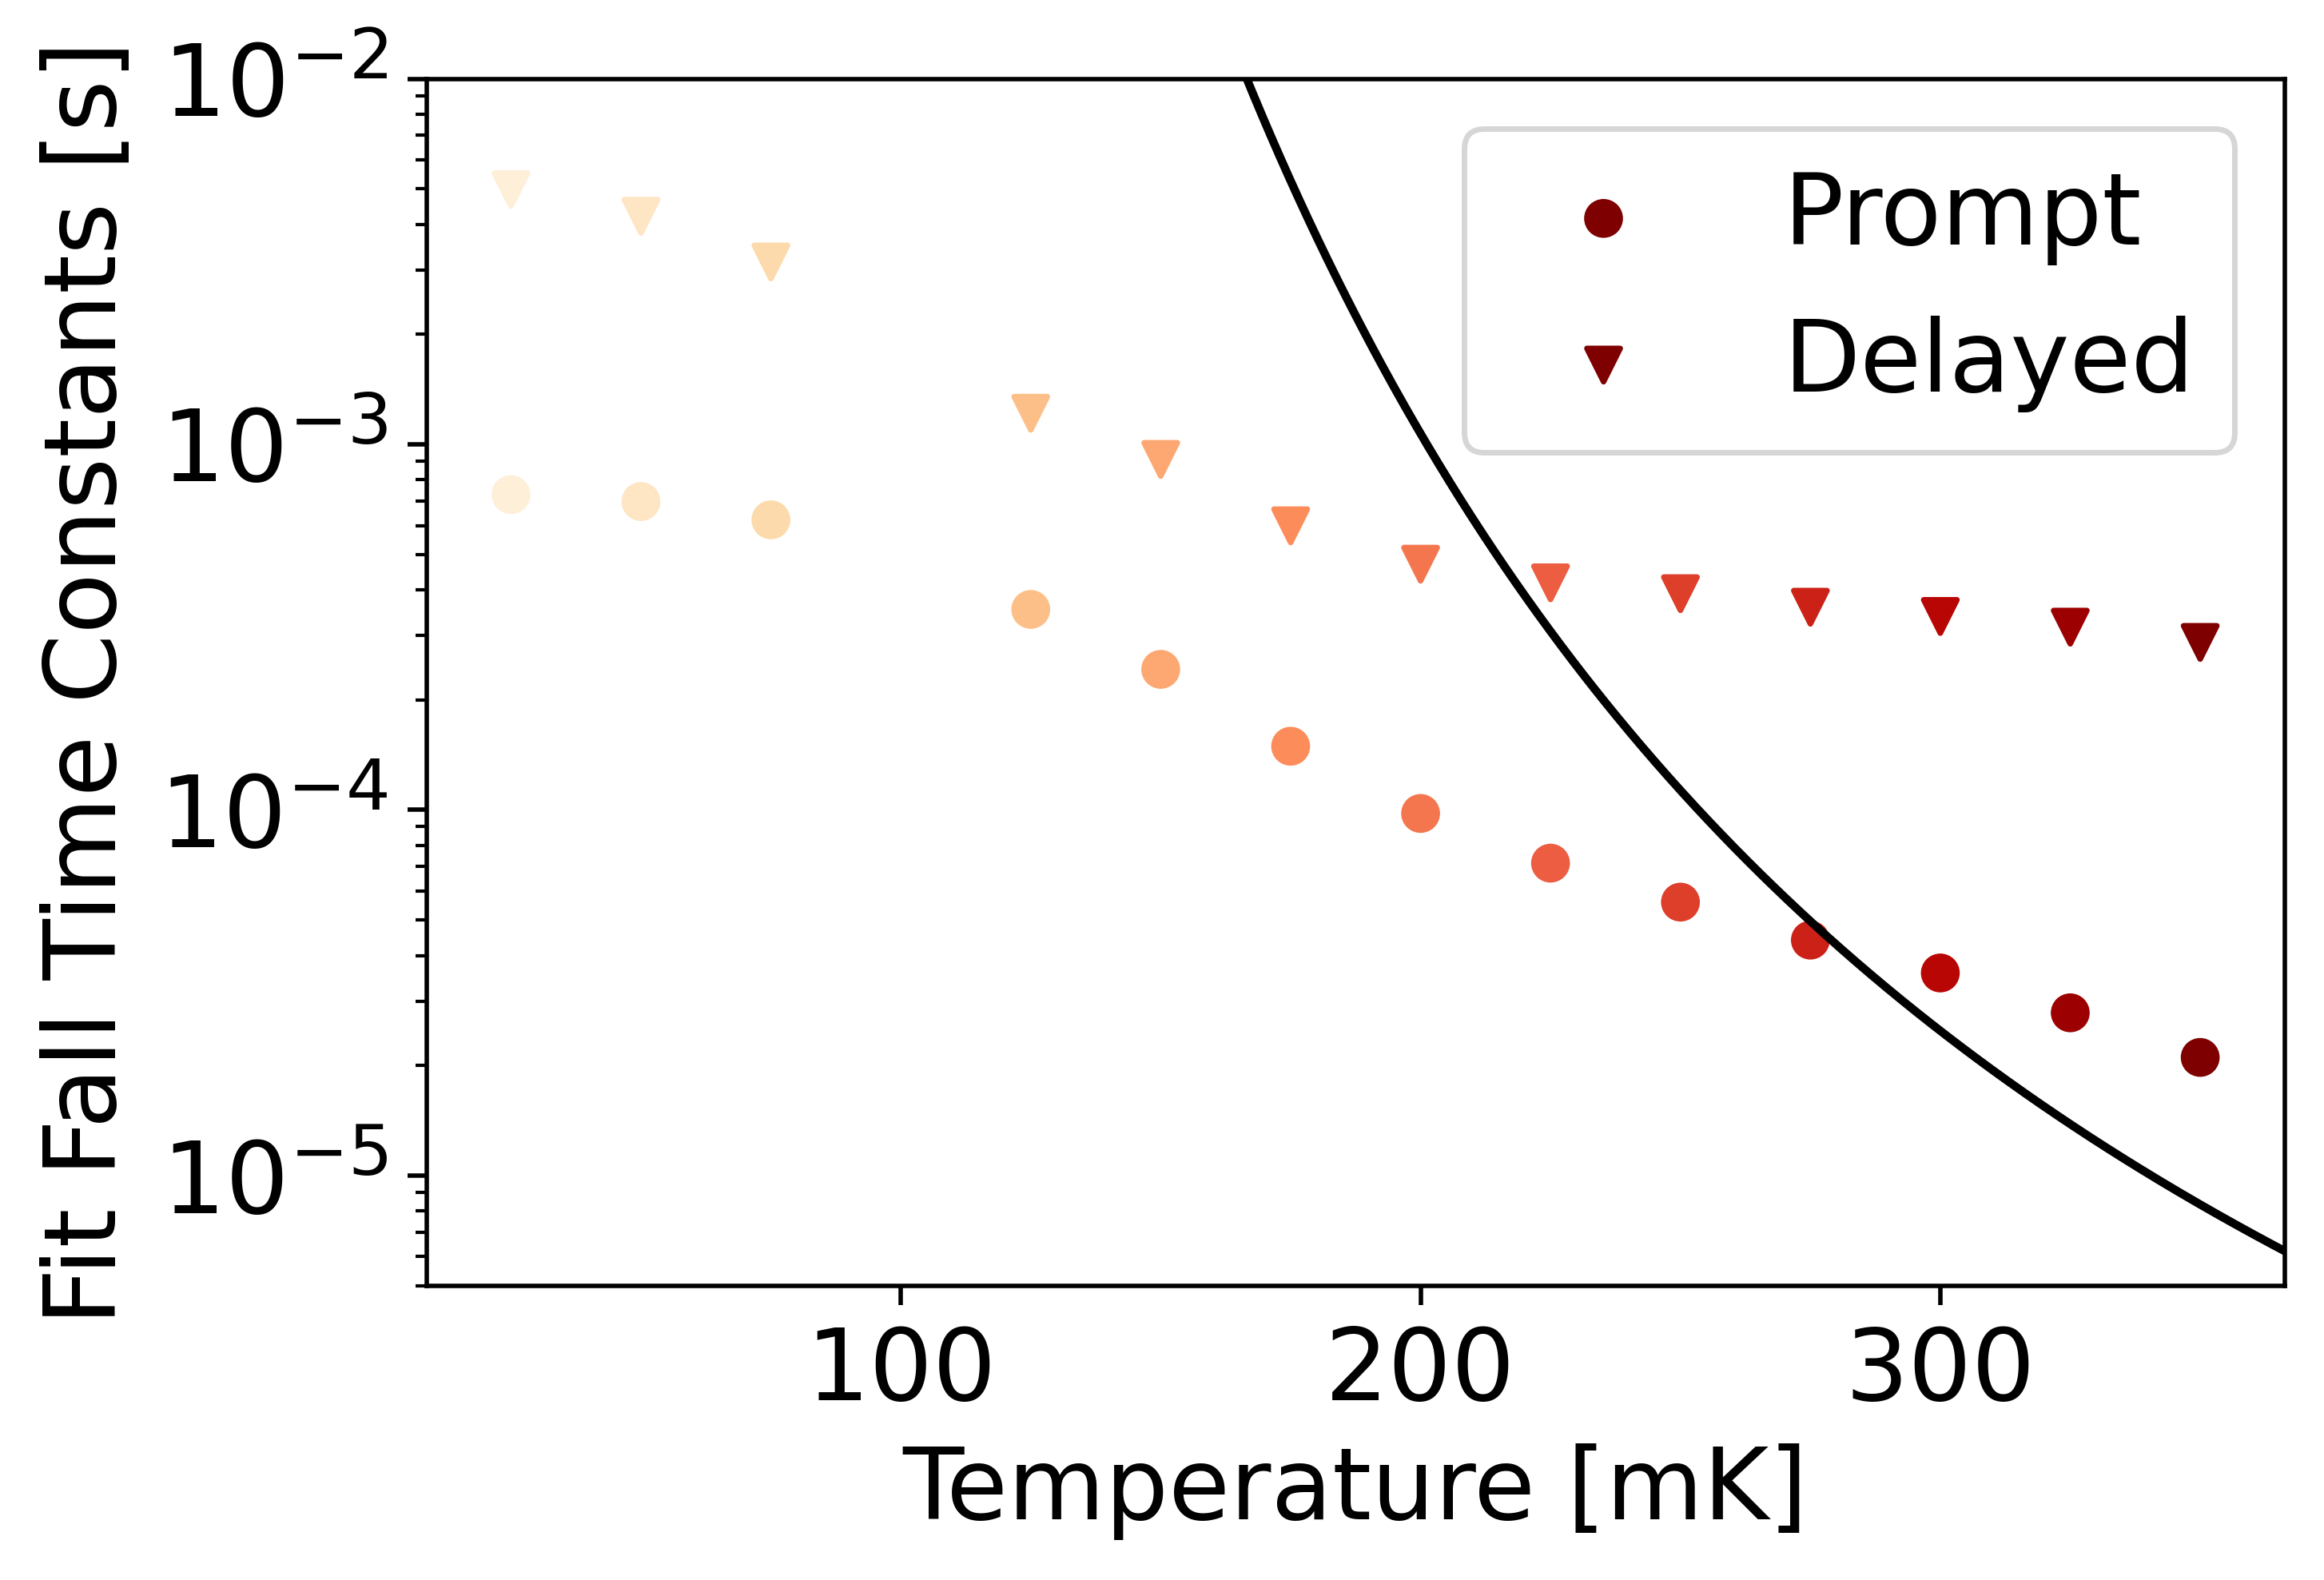

In [11]:
ax = plt.figure(dpi=500).gca()
ax.scatter(temps_mK,prompt_fall_ms*1e-3,c=cmap( temps_mK / np.max(temps_mK) ),marker='o',label="Prompt")
ax.scatter(temps_mK,delayd_fall_ms*1e-3,c=cmap( temps_mK / np.max(temps_mK) ),marker='v',label="Delayed")
ax.set_xlabel("Temperature [mK]")
ax.set_ylabel("Fit Fall Time Constants [s]")
if True:
    ylims = ax.get_ylim()
    ax.set_ylim([0.3*np.min(lifetimes[delayd_fall_ms>0]*1e-3) , 2*ylims[1]])
    if True:
        ax.set_ylim([5e-6,1e-2])
    ax.set_yscale('log')
if True:
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    xrange = np.linspace(start=xlims[0],stop=xlims[1],num=1000)
    theory = theory_curve(xrange/1e3,Tc,Delta,tau0)
    ax.plot(xrange,theory,'k-')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
ax.legend(loc='best')

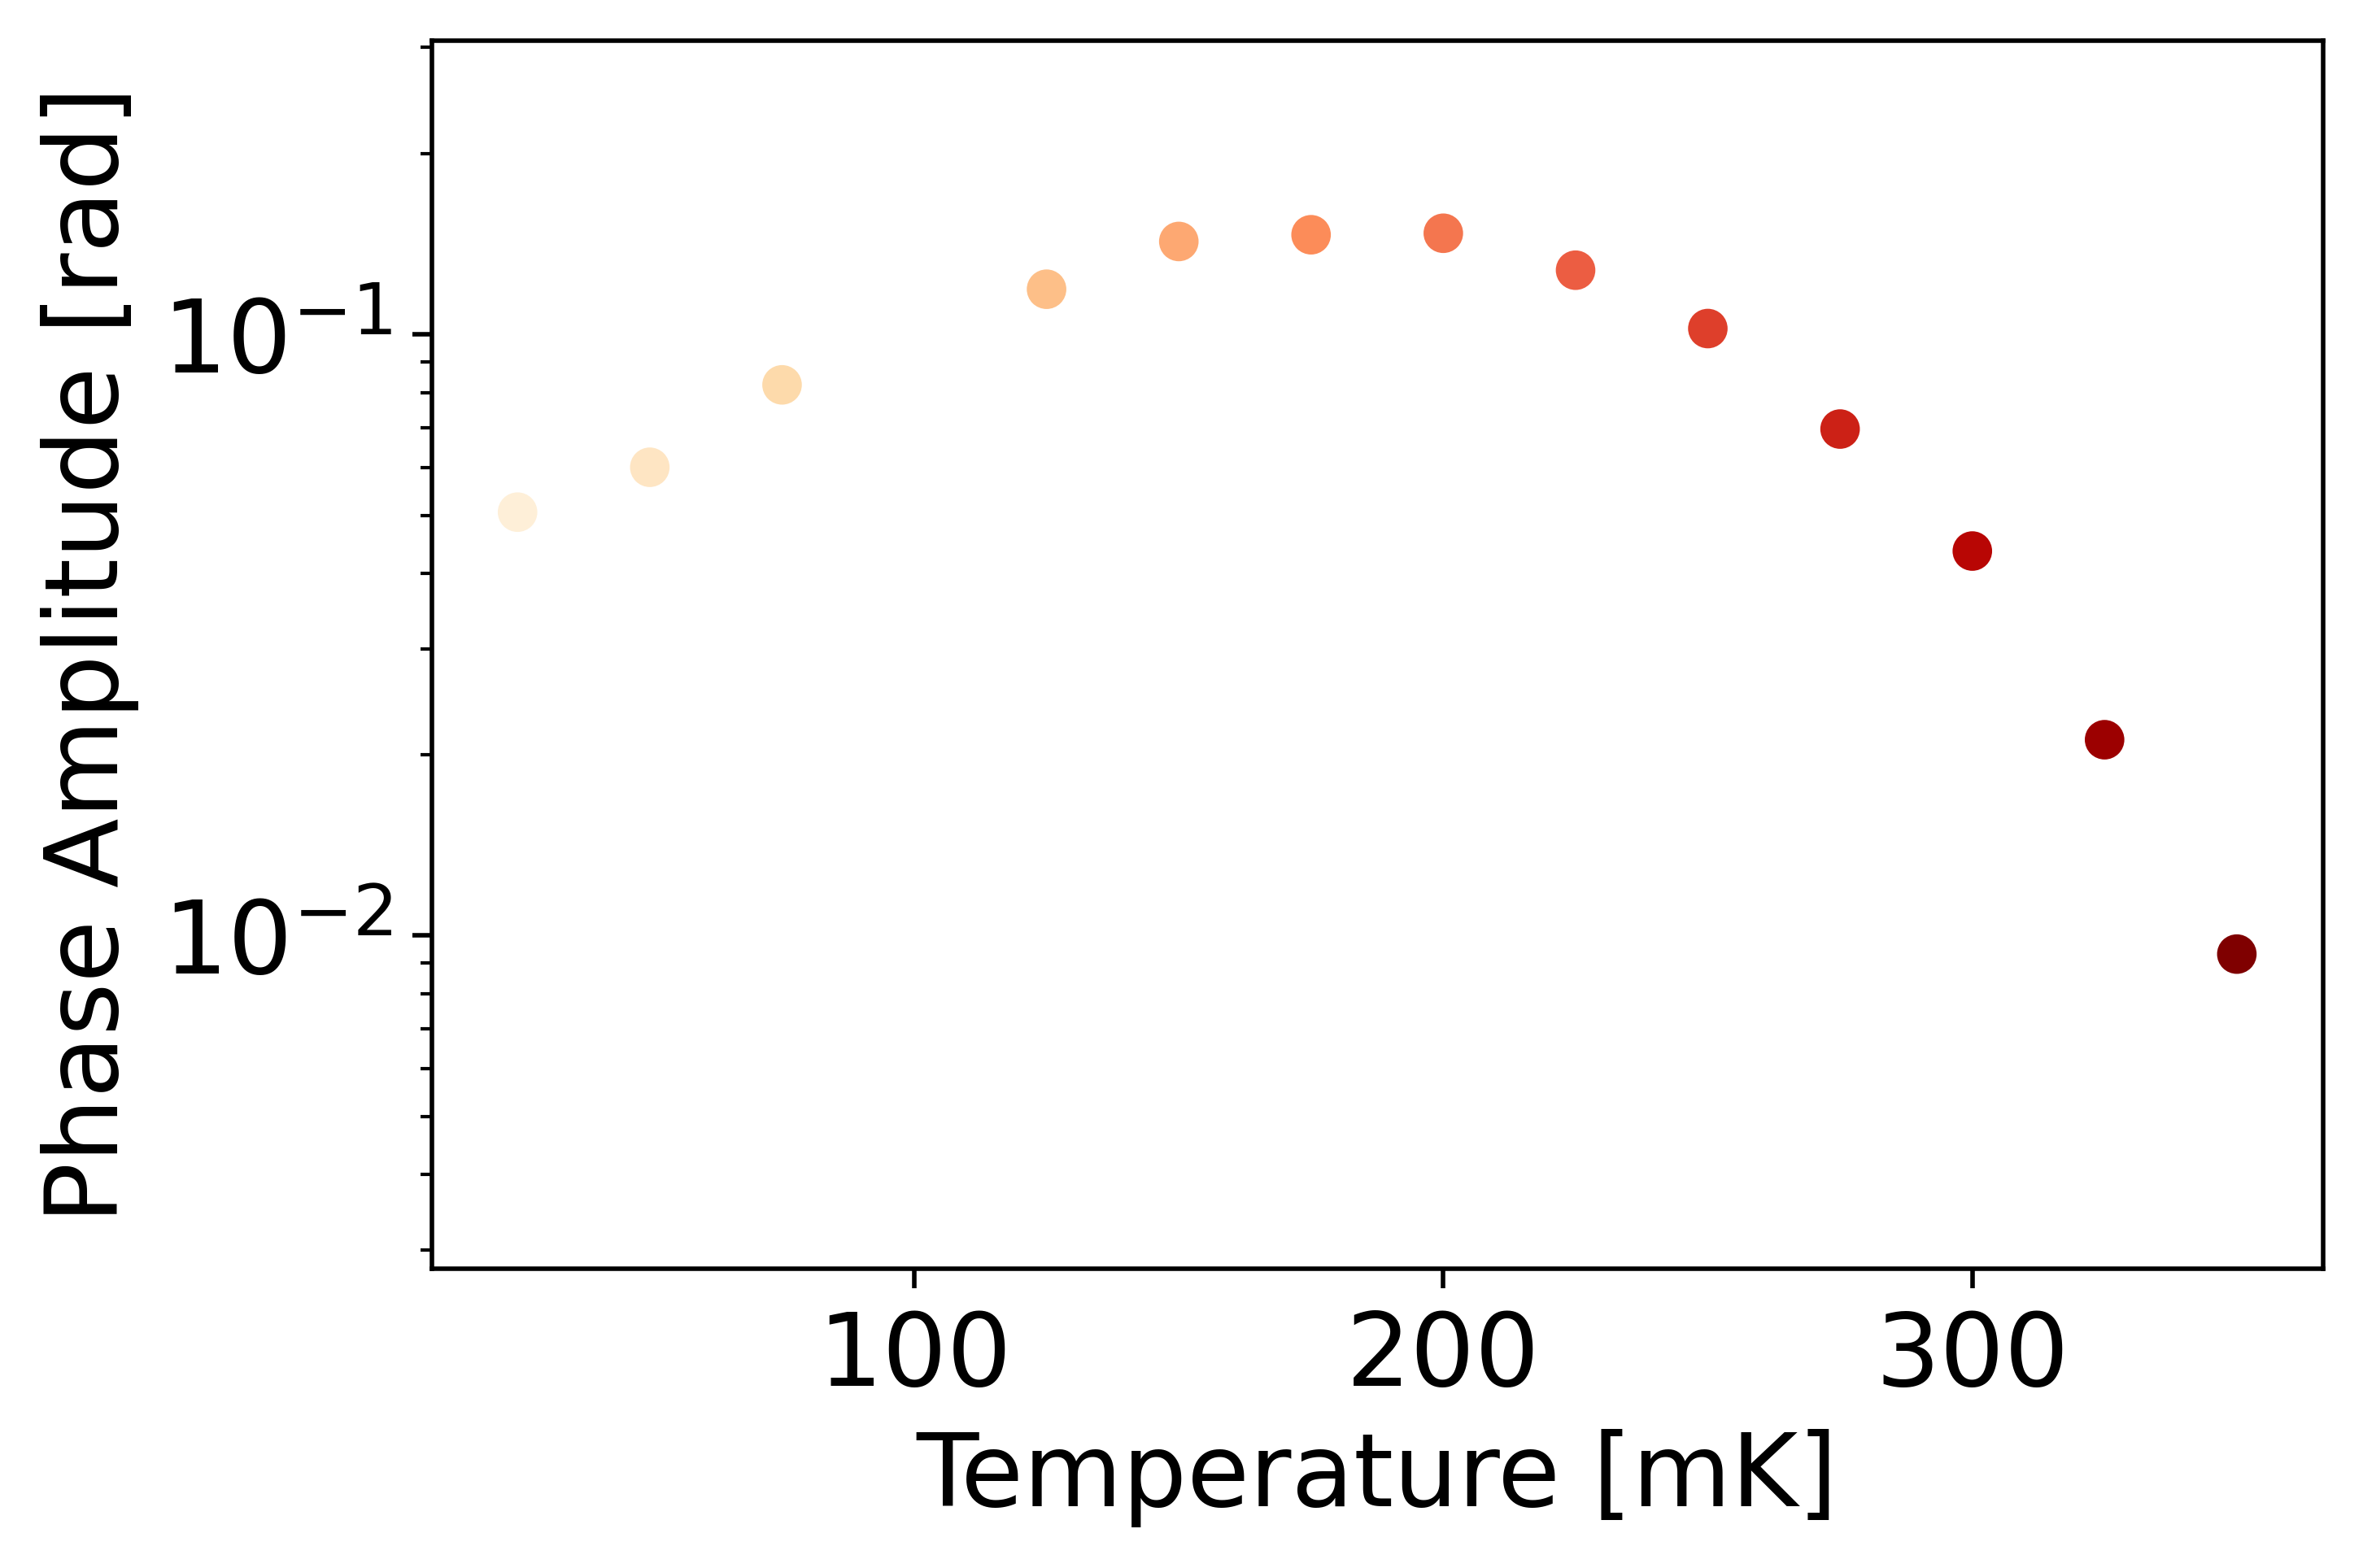

In [12]:
ax = plt.figure(dpi=500).gca()
ax.scatter(temps_mK,pulse_max_phse,c=cmap( temps_mK / np.max(temps_mK) ),marker='o')
ax.set_xlabel("Temperature [mK]")
ax.set_ylabel("Phase Amplitude [rad]")
if True:
    ylims = ax.get_ylim()
    ax.set_ylim([0.3*np.min(pulse_max_phse[pulse_max_phse>0]) , 2*ylims[1]])
    ax.set_yscale('log')